In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc
from functools import partial
import time
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition, h5_handling, math_functions, misc, plotting_helpers, path_helpers, indexing

%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%autoreload 2
import bmi_idap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline

In [6]:
params = {}
results = {}

In [7]:
results['general'] = {}

results['general']['datetime'] = str(datetime.datetime.now())
results['general']['cwd'] = os.getcwd()

In [8]:
params['paths'] = {}

# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/').resolve())
params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/').resolve())

## Directory with F.npy, stat.npy etc.
# params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve())
# params['paths']['dir_s2p']     = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve())
params['paths']['dir_s2p_outer']   = str(Path(r'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/').resolve())

## Path of z-stack and z-position trace
# params['paths']['path_zStack']    = str(Path('/media/rich/bigSSD/data_raw/BMI/mouse_0315N/20230404_day0/scanimage_data/zstack/zstack_00001_00001.tif'))
## params['paths']['path_zPosition'] = str(Path('/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/z_positions.h5'))


## Path of iscell. Can be from neural net output (iscell_NN)
params['paths']['path_iscell'] = str(Path(params['paths']['dir_analysisFiles']) / 'iscell_classifier_matching_tqm.pkl')

## Path of tqm (trace quality metrics). Used to get dFoF parameters
params['paths']['path_tqm'] = str(Path(params['paths']['dir_analysisFiles']) / 'trace_quality.pkl')


params['paths']['dir_save']       =  copy.copy(params['paths']['dir_analysisFiles'])
params['paths']['path_save_weights'] = str(Path(params['paths']['dir_save']) / 'weights_day0')
params['paths']['path_save_results'] = str(Path(params['paths']['dir_save']) / 'decoder_definition')

In [9]:
params['general'] = {}

params['general']['use_gpu'] = True

In [10]:
device = torch_helpers.set_device(use_GPU=params['general']['use_gpu'])

results['device'] = device

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


# IMPORT DATA

In [11]:
outs = file_helpers.pickle_load(params['paths']['path_iscell'])
iscell = outs['iscell_classifier_matching_tqm']
ucids = outs['UCIDs_classifier_matching_tqm']

tqm = file_helpers.pickle_load(params['paths']['path_tqm'])
# z_positions = h5_handling.simple_load(params['paths']['path_zPositions'], return_lazy=False)['zPositions']

In [13]:
filepaths_F = path_helpers.find_paths(
    dir_outer=params['paths']['dir_s2p_outer'],
    reMatch='F.npy',
    depth=3,
)[2:4]
print(f'filepaths with F.npy:')
[print(f' {f}') for f in filepaths_F]

dirs_s2p = [str(Path(p).parent) for p in filepaths_F]
params['paths']['dirs_s2p'] = dirs_s2p

filepaths with F.npy:
 /media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230424/F.npy
 /media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230425/F.npy


In [14]:
## == IMPORT DATA ==
outs = [ca2p_preprocessing.import_s2p(d) for d in dirs_s2p]
F_all, Fneu_all, iscell_s2p_all, ops_all, spks_s2p_all, stat_all = ([o[ii] for o in outs] for ii in range(len(outs[0])))

In [15]:
use_multiple_sessions = True

if use_multiple_sessions:
    F_matched, Fneu_matched = (roicat.util.match_arrays_with_ucids(f, ucids) for f in (F_all, Fneu_all))
    tqm_metrics_matched = [{key: val[tqm['iscell_tqm'][i_sesh]] for key, val in t['metrics'].items()} for i_sesh, t in enumerate(tqm['tqm'])]
else:
    F_matched, Fneu_matched = [f[ic] for f,ic in zip(F_all, iscell)], [f[ic] for f,ic in zip(Fneu_all, iscell)]
    tqm_metrics_matched = [{key: val[tqm['iscell_classifier_matching_tqm'][i_sesh]] for key, val in t['metrics'].items()} for i_sesh, t in enumerate(tqm['tqm'])]

In [16]:
n_rois, n_sessions = F_matched[0].shape[0], len(F_matched)
Fs = ops_all[0]['fs']

In [18]:
params['ROIs'] = {}

params['ROIs']['idx_session_toUse'] = -1
params['ROIs']['path_session_toUse'] = dirs_s2p[-1]


stat = copy.deepcopy(stat_all[params['ROIs']['idx_session_toUse']])
ops =  copy.deepcopy(ops_all[params['ROIs']['idx_session_toUse']])

frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

data_rois = roicat.data_importing.Data_suite2p([str(Path(p).resolve() / 'stat.npy') for p in params['paths']['dirs_s2p']], FOV_height_width=(frame_height, frame_width))
sf_sessionToUse_all    = data_rois.spatialFootprints
sfneu_sessionToUse_all = data_rois.import_neuropil_masks()

# sf_sessionToUse_all = roicat.data_importing.Data_suite2p._transform_statFile_to_spatialFootprints(
#     frame_height_width=(frame_height, frame_width),
#     stat=stat,
#     normalize_mask=False,
# )
sf_sessionToUse_matched    = roicat.util.match_arrays_with_ucids(sf_sessionToUse_all[params['ROIs']['idx_session_toUse']], ucids[-1])[0] if use_multiple_sessions else [sf[ic] for sf,ic in zip(sf_sessionToUse_all, iscell)][params['ROIs']['idx_session_toUse']]
sfneu_sessionToUse_matched = roicat.util.match_arrays_with_ucids(sfneu_sessionToUse_all[params['ROIs']['idx_session_toUse']], ucids[-1])[0] if use_multiple_sessions else [sf[ic] for sf,ic in zip(sfneu_sessionToUse_all, iscell)][params['ROIs']['idx_session_toUse']]
 
results['ROIs'] = {}
results['ROIs']['spatial_footprints_all'] = sf_sessionToUse_all
results['ROIs']['spatial_footprints_matched'] = sf_sessionToUse_matched.tocsr()
results['ROIs']['sfneu_all'] = sfneu_sessionToUse_all
results['ROIs']['sfneu_matched'] = sfneu_sessionToUse_matched.tocsr()

Completed: Set FOV_height and FOV_width successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.60it/s]


Imported 2 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 2 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.
Importing neuropil masks from stat files.


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


Imported 2 sessions of neuropil masks into sparse arrays.


In [19]:
results['data'] = {}

results['data']['n_rois'] = n_rois
results['data']['Fs'] = Fs
results['data']['frame_height'] = frame_height
results['data']['frame_width'] = frame_width


In [21]:
sf_sessionToUse_matched

<238x524288 sparse matrix of type '<class 'numpy.float64'>'
	with 22456 stored elements in List of Lists format>

In [20]:
sf_neuropil = scipy.sparse.vstack(
    [scipy.sparse.csr_matrix(
            (np.ones(len(s['neuropil_mask'])), np.unravel_index(s['neuropil_mask'], shape=(frame_height,frame_width), order='C')), 
            shape=(frame_height, frame_width), 
            dtype=bool
        ).reshape(1,-1) for s in tqdm(stat)]
).tocsr()

  0%|          | 0/2464 [00:00<?, ?it/s]

In [79]:
zstack_dense = ca2p_preprocessing.import_tiffs_SI(
    params['paths']['path_zStack'],
#     clip_zero=True,
    dtype=None,
)

KeyError: 'path_zStack'

In [ ]:
params['zstack'] = {}

params['zstack']['frames_to_discard_per_slice'] = 30
params['zstack']['sparse_step_size_um'] = 0.8

zstack_sparse, positions_z, idx_slices = ca2p_preprocessing.dense_stack_to_sparse_stack_SI(
    stack_in=zstack_dense,
    scanimage_metadata=ca2p_preprocessing.get_ScanImage_tiff_metadata(params['paths']['path_zStack']),
    frames_to_discard_per_slice=params['zstack']['frames_to_discard_per_slice'],
    sparse_step_size_um=params['zstack']['sparse_step_size_um'],
    reduction=partial(np.percentile, q=30),
)

results['zstack'] = {}

results['zstack']['zstack_sparse'] = zstack_sparse
results['zstack']['positions_z'] = positions_z
results['zstack']['idx_slices'] = idx_slices


In [ ]:
plotting_helpers.display_toggle_image_stack(zstack_sparse)

In [ ]:
import sparse

sf_sparse = sparse.COO(sf).reshape((sf.shape[0], frame_height, frame_width))
sf_neuropil_sparse = sparse.COO(sf_neuropil).reshape((sf_neuropil.shape[0], frame_height, frame_width))

# F_dZ    = (zstack_sparse[:,None,:,:] * sf_sparse[None,:,:,:]).sum(axis=(-2,-1)).todense()
F_dZ = ((zstack_sparse[:,None,:,:] * sf_sparse[None,:,:,:]).sum(axis=(-2,-1)) / sf_sparse.sum(axis=(-2,-1))).todense()
Fneu_dZ = ((zstack_sparse[:,None,:,:] * sf_neuropil_sparse[None,:,:,:]).sum(axis=(-2,-1)) / sf_neuropil_sparse.sum(axis=(-2,-1))).todense()

# FneuSub_dZ = F_dZ - Fneu_dZ*params['dFoF']['neuropil_fraction']

params['zstack']['sig_smooth_z'] = 1.5
# FneuSub_dZ_conv = timeSeries.simple_smooth(FneuSub_dZ, x=np.linspace(-FneuSub_dZ.shape[0]//2, FneuSub_dZ.shape[0]//2, FneuSub_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)
F_dZ_conv = timeSeries.simple_smooth(F_dZ, x=np.linspace(-F_dZ.shape[0]//2, F_dZ.shape[0]//2, F_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)
Fneu_dZ_conv = timeSeries.simple_smooth(Fneu_dZ, x=np.linspace(-Fneu_dZ.shape[0]//2, Fneu_dZ.shape[0]//2, Fneu_dZ.shape[0]), sig=params['zstack']['sig_smooth_z'], axis=0)

results['zstack']['F_dZ'] = F_dZ
results['zstack']['Fneu_dZ'] = Fneu_dZ
results['zstack']['F_dZ_conv'] = F_dZ_conv
results['zstack']['Fneu_dZ_conv'] = Fneu_dZ_conv

visually check out the trace and distribution of the z_positions time series to see where the 'baseline' / 0-point is

In [ ]:
params['zstack']['z0_component'] = -1.7
params['zstack']['dZ_component'] = 6

idx_position_0 = np.abs(np.array(positions_z) + params['zstack']['z0_component']).argmin()
idx_position_plus = np.abs(np.array(positions_z) + params['zstack']['dZ_component']).argmin()
idx_position_minus = np.abs(np.array(positions_z) - params['zstack']['dZ_component']).argmin()

FoF_dZ_conv = F_dZ_conv / F_dZ_conv[idx_position_0]
FneuoF_dZ_conv = Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0]

FneuSub_dZ_conv = F_dZ_conv - 0.7*Fneu_dZ_conv
dFneuSuboF_dZ_conv = (FneuSub_dZ_conv - FneuSub_dZ_conv[idx_position_0]) / FneuSub_dZ_conv[idx_position_0]
# dFoF_dZ_conv = ((F_dZ_conv - Fneu_dZ_conv*0.7) - (F_dZ_conv - Fneu_dZ_conv*0.7)[idx_position_0]) / (F_dZ_conv - Fneu_dZ_conv*0.7)[idx_position_0]

component_z_plus = dFneuSuboF_dZ_conv[idx_position_plus]
component_z_minus = dFneuSuboF_dZ_conv[idx_position_minus]

results['zstack']['idx_position_0'] = idx_position_0
results['zstack']['idx_position_plus'] = idx_position_plus
results['zstack']['idx_position_minus'] = idx_position_minus
results['zstack']['FoF_dZ_conv'] = FoF_dZ_conv
results['zstack']['FneuoF_dZ_conv'] = FneuoF_dZ_conv
# results['zstack']['component_z_plus'] = component_z_plus
# results['zstack']['component_z_minus'] = component_z_minus

In [ ]:
plt.figure()
# plt.plot(positions_z, F_dZ[:,:200]);
plt.plot(positions_z, (F_dZ_conv / F_dZ_conv[idx_position_0])[:,:10]);
# plt.plot(positions_z, Fneu_dZ[:,:200]);
# plt.plot(positions_z, (Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0])[:,:20]);
plt.xlabel('z position')
plt.ylabel('F ratio')
plt.title('F or Fneu / dZ')

In [ ]:
plt.figure()
plt.plot(component_z_plus[iscell])

In [ ]:
plt.figure()
# plt.plot(positions_z, F_dZ[:,:200]);
# plt.plot(positions_z, (F_dZ_conv / F_dZ_conv[idx_position_0])[:,:200]);
plt.plot(positions_z, dFneuSuboF_dZ_conv[:,iscell])
# plt.plot(positions_z, FneuSub_dZ_conv[:,iscell][:,:])
# plt.plot(positions_z, Fneu_dZ[:,:]);
# plt.plot(positions_z, (Fneu_dZ_conv / Fneu_dZ_conv[idx_position_0])[:,:20]);
plt.xlabel('z position')
plt.ylabel('F ratio')
plt.title('F or Fneu / dZ')

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(component_z_plus[iscell], 200);
axs[0].hist(component_z_minus[iscell], 200);
axs[0].set_xlabel('component value')
axs[0].set_ylabel('counts')

axs[1].scatter(component_z_minus[iscell], component_z_plus[iscell], alpha=0.1)
axs[1].grid()
axs[1].set_xlabel('component_z_minus')
axs[1].set_ylabel('component_z_plus');

In [ ]:
np.argmin(component_z_plus[iscell])

In [ ]:
component_z_plus.shape

Calculate the expected dF/F scaling factor at each time point for each ROI. Interpolate the expected `FneuSubOF_dZ` value for each neuron at the calculated z-position for that frame.

# Prepare dFoF

In [173]:
params['dFoF'] = {}

# params['dFoF']['idx_sessions_toUse'] = list(np.arange(n_sessions, dtype=int))
params['dFoF']['idx_sessions_toUse'] = [1]

In [20]:
params['dFoF']['channelOffset_correction'] = tqm['dFoF_params']['channelOffset_correction']
params['dFoF']['percentile_baseline'] = tqm['dFoF_params']['percentile_baseline']
params['dFoF']['neuropil_fraction'] = tqm['dFoF_params']['neuropil_fraction']
params['dFoF']['win_rolling_percentile'] = int(10*60*results['data']['Fs'])  ## In frames
params['dFoF']['roll_stride'] = 10  ## In frames

In [21]:
outs = [ca2p_preprocessing.make_dFoF(
    F=F_matched[idx_sesh],
    Fneu=Fneu_matched[idx_sesh],
    neuropil_fraction=params['dFoF']['neuropil_fraction'],
    percentile_baseline=params['dFoF']['percentile_baseline'],
    rolling_percentile_window=int(params['dFoF']['win_rolling_percentile']),
    channelOffset_correction=params['dFoF']['channelOffset_correction'],
    roll_stride=params['dFoF']['roll_stride'],
    multicore_pref=True,
    verbose=True
) for idx_sesh in params['dFoF']['idx_sessions_toUse']]

dFoF_roll_matched , dF_roll_matched , F_roll_neuSub_matched , F_roll_baseline_matched = ([outs[i_sesh][i_out] for i_sesh in range(len(params['dFoF']['idx_sessions_toUse']))] for i_out in range(len(outs[0])))


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 231.76it/s]


Calculated dFoF. Total elapsed time: 1.77 seconds


In [22]:
idx_time_bad = [np.arange(0,8000),]  ## list removing time points from each session
# idx_time_bad =+ np.where(np.abs(z_positions) > params['dFoF']['max_z_displacement'])[0]

idx_time_good = [np.arange(F_all[i_sesh].shape[1])[~np.isin(np.arange(F_all[i_sesh].shape[1]), idx_time_bad)] for i_sesh in params['dFoF']['idx_sessions_toUse']]
#                             np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

results['idx_time_bad'] = idx_time_bad

In [23]:
idx_time_good

[array([  8000,   8001,   8002, ..., 107997, 107998, 107999])]

In [24]:
dFoF        = np.concatenate([dFoF_roll_matched[i_sesh][:, idx_time_good[i_sesh]] for i_sesh in range(len(params['dFoF']['idx_sessions_toUse']))] , axis=1)
Fneu_toUse  = np.concatenate([Fneu_matched[i_sesh][:, idx_time_good[i_sesh]]      for i_sesh in range(len(params['dFoF']['idx_sessions_toUse']))] , axis=1)

In [25]:
dFoF_centered        = np.concatenate([(dFoF_roll_matched[i_sesh] - dFoF_roll_matched[i_sesh].mean(1, keepdims=True))[:, idx_time_good[i_sesh]] for i_sesh in range(len(params['dFoF']['idx_sessions_toUse']))] , axis=1)
Fneu_toUse_centered  = np.concatenate([(Fneu_matched[i_sesh] - Fneu_matched[i_sesh].mean(1, keepdims=True))[:, idx_time_good[i_sesh]]           for i_sesh in range(len(params['dFoF']['idx_sessions_toUse']))] , axis=1)

In [26]:
idx_session = np.concatenate([np.ones(f.shape[1], dtype=np.int64)*ii for ii,f in enumerate(Fneu_matched)])[idx_time_good]

In [27]:
np.sum(dFoF > 30)

0

In [28]:
# dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [29]:
import rastermap

In [30]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [31]:
# X = scipy.stats.zscore(dFoF, axis=0).T
# X = scipy.stats.zscore(dFoF, axis=1)
# X = dFoF / np.std(dFoF, axis=1, keepdims=True)
X = dFoF_centered.copy()
rmap.fit(X)

nmin 200
0.03285980224609375
3.4116697311401367
3.632276773452759
3.63344144821167
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.27s     0        0.1125      2
0.29s    10        0.2419      4
0.32s    20        0.2914      8
0.34s    30        0.3593      18
0.36s    40        0.4134      28
0.38s    50        0.4637      38
0.41s    60        0.4638      38
0.44s   final      0.4639
0.44s upsampled    0.4639


<IPython.core.display.Javascript object>


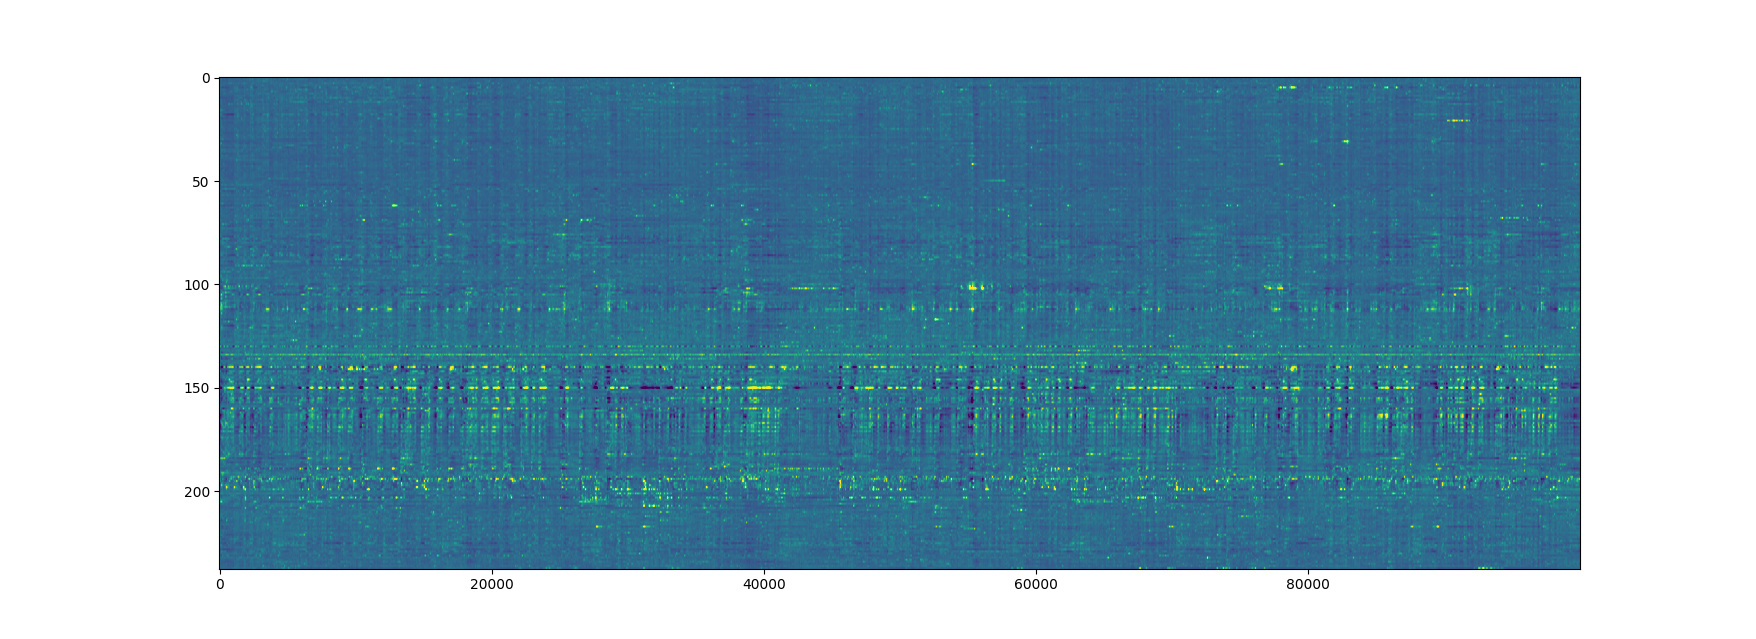

In [80]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort][:], aspect='auto', vmin=-0.4, vmax=1)

# %matplotlib inline

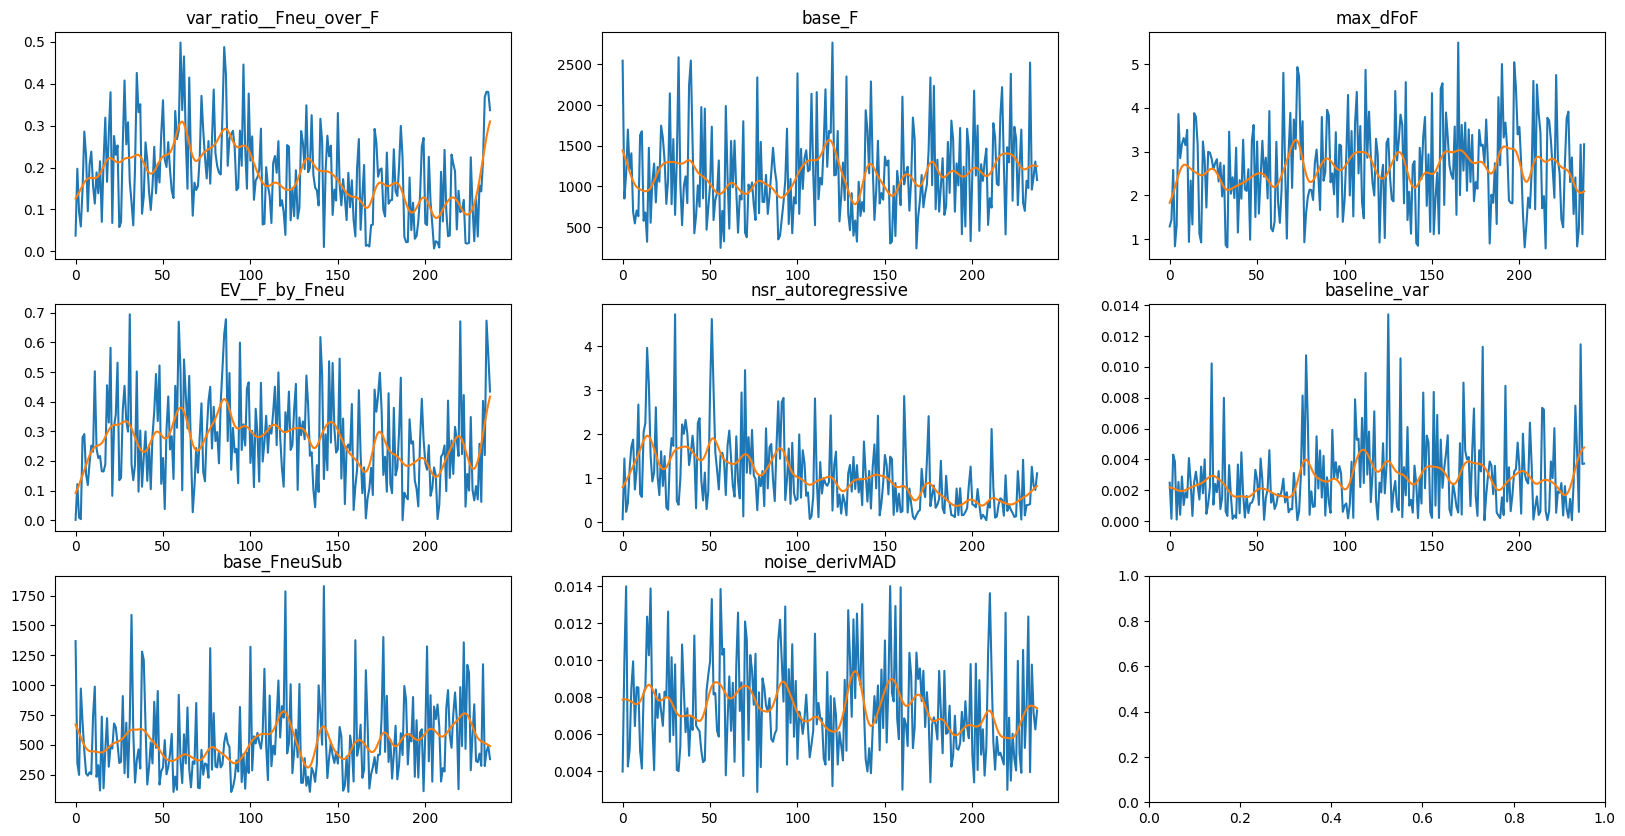

In [33]:
%matplotlib inline

n_keys = len(tqm_metrics_matched[0].keys())
n_grid = int(np.ceil(n_keys**0.5))
fig, axs = plt.subplots(n_grid, n_grid, figsize=(20,10))
idx_axs = plotting_helpers.get_subplot_indices(axs)
for ii, (key, val) in enumerate(tqm_metrics_matched[0].items()):
    axs[idx_axs[ii]].set_title(key)
    axs[idx_axs[ii]].plot(val[rmap.isort])
    axs[idx_axs[ii]].plot(timeSeries.simple_smooth(val[rmap.isort], sig=5))

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [34]:
params['preorthogonalization'] = {}

params['preorthogonalization']['bandpass_freqs_boundaries'] = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]
params['preorthogonalization']['mspline_grid_order'] = 3
params['preorthogonalization']['mspline_grid_numSplines'] = 4
params['preorthogonalization']['num_taps'] = 10001
params['preorthogonalization']['window'] = ('kaiser', 3.0)

In [35]:
dFoF_centered_mean = np.nanmean(dFoF_centered, axis=0)
Fneu_centered_mean = np.nanmean(Fneu_toUse_centered, axis=0)

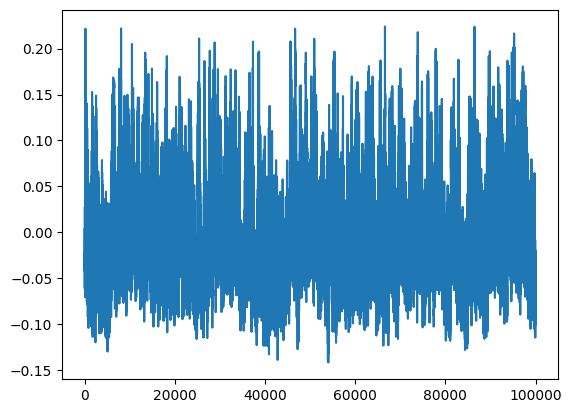

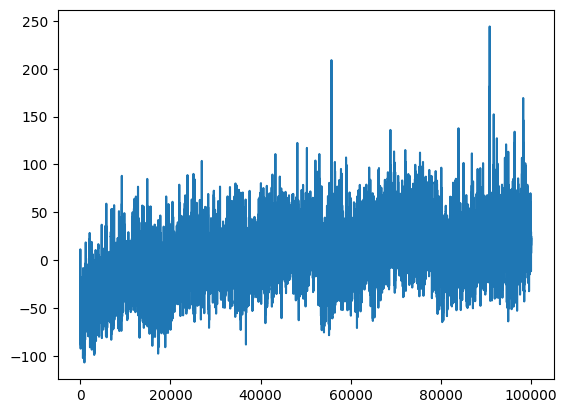

In [36]:
plt.figure()
plt.plot(dFoF_centered_mean)

plt.figure()
plt.plot(Fneu_centered_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [37]:
bpfb = params['preorthogonalization']['bandpass_freqs_boundaries'] 

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=params['preorthogonalization']['num_taps'], fs=Fs, window=params['preorthogonalization']['window'], plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bpfb[:-1], bpfb[1:]))]

In [38]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

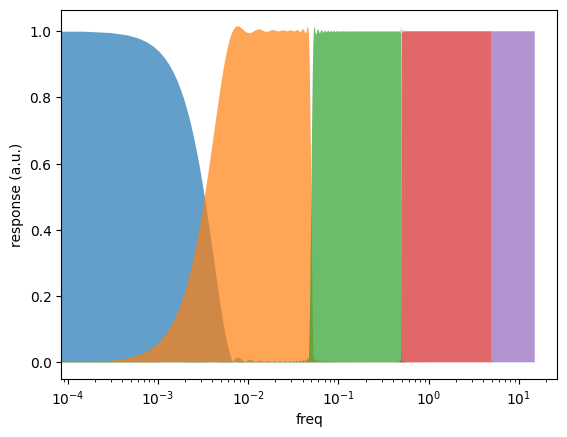

In [39]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [40]:
sigs_list = [scipy.signal.filtfilt(h, 1.0, dFoF_centered_mean - dFoF_centered_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_centered_mean - Fneu_centered_mean.mean()) for h in tqdm(bandpass_ab[:])] + \
    [np.linspace(-1, 1, dFoF_centered.shape[1], endpoint=True)] + \
    [np.ones(dFoF.shape[1])] + \
    list(featurization.mspline_grid(order=params['preorthogonalization']['mspline_grid_order'], num_basis_funcs=params['preorthogonalization']['mspline_grid_numSplines'], nt=dFoF_centered.shape[1])) + \
    list(np.stack([np.array(idx_session==ii).squeeze() for ii in range(len(idx_session))], axis=0))

sigs = np.stack(sigs_list, axis=0,).astype(np.float32)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


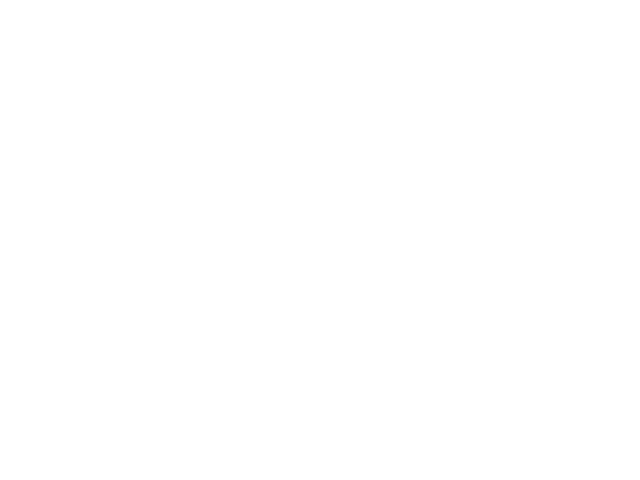

<IPython.core.display.Javascript object>


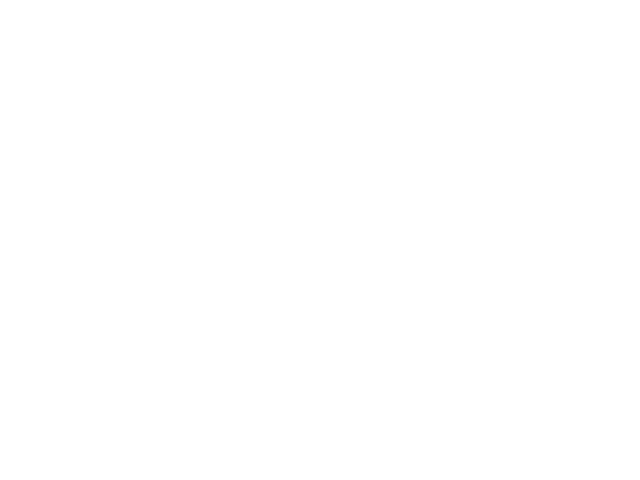

In [41]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_centered_mean - dFoF_centered_mean.mean())

# %matplotlib inline

In [42]:
v1_orth, EVR, EVR_total, pca_dict = similarity.orthogonalize((dFoF_centered - dFoF_centered_mean).T, sigs.T, method='OLS', device=device)

dFoF_orth = (v1_orth.T - np.percentile(v1_orth.T, params['dFoF']['percentile_baseline'], axis=1)[:,None]).astype(np.float32)

print(f"Total variance ratio in dFoF orthogonalized out: {EVR_total :.4f}")

Total variance ratio in dFoF orthogonalized out: 0.1271


In [43]:
results['preorthogonalization'] = {}

results['preorthogonalization']['signals'] = sigs
results['preorthogonalization']['EVR_total'] = EVR_total
results['preorthogonalization']['dFoF_centered_mean'] = dFoF_centered_mean
results['preorthogonalization']['Fneu_centered_mean'] = Fneu_centered_mean

In [44]:
import rastermap

In [45]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [46]:
X = dFoF_orth.copy()
# X = dFoF_orth / np.std(dFoF_orth, axis=1, keepdims=True)
# X = timeSeries.simple_smooth(X, sig=4, axis=1)
rmap.fit(X)

nmin 200
0.03334975242614746
6.423748731613159
6.877895832061768
6.879163980484009
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0683      2
0.07s    10        0.1683      4
0.14s    20        0.2158      8
0.20s    30        0.3031      18
0.26s    40        0.3565      28
0.31s    50        0.4084      38
0.34s    60        0.4105      38
0.40s   final      0.4105
0.40s upsampled    0.4105


<IPython.core.display.Javascript object>


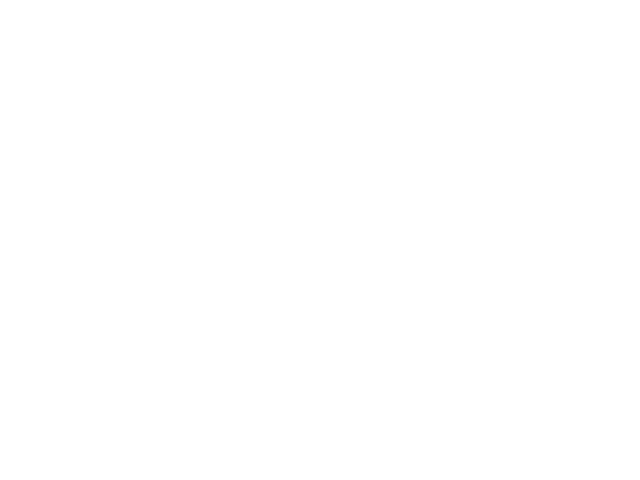

In [47]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)

# %matplotlib inline

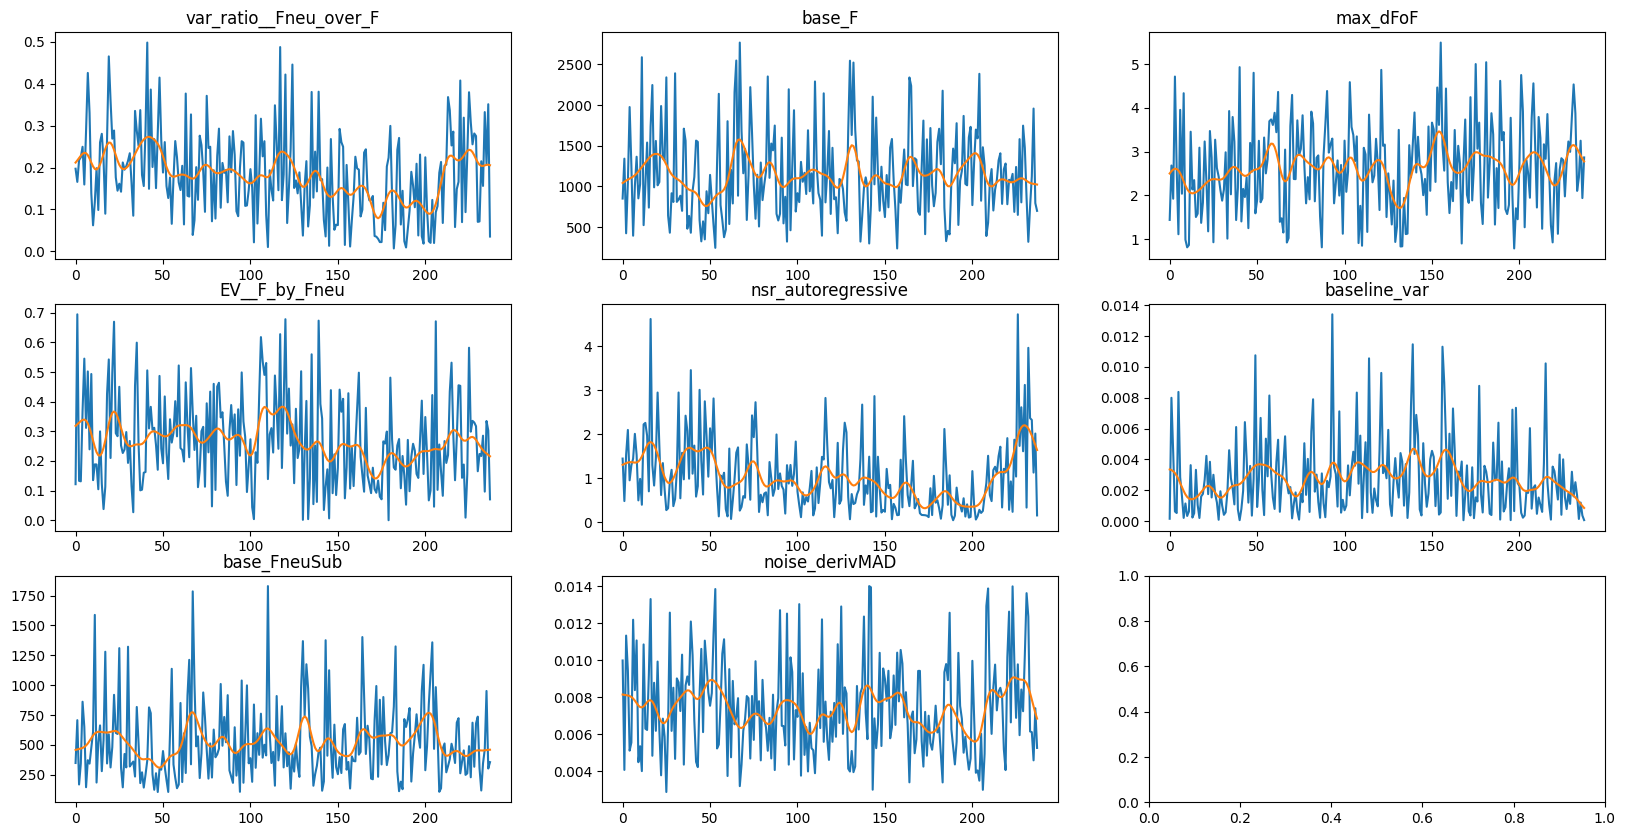

In [48]:
%matplotlib inline

n_keys = len(tqm_metrics_matched[0].keys())
n_grid = int(np.ceil(n_keys**0.5))
fig, axs = plt.subplots(n_grid, n_grid, figsize=(20,10))
idx_axs = plotting_helpers.get_subplot_indices(axs)
for ii, (key, val) in enumerate(tqm_metrics_matched[0].items()):
    axs[idx_axs[ii]].set_title(key)
    axs[idx_axs[ii]].plot(val[rmap.isort])
    axs[idx_axs[ii]].plot(timeSeries.simple_smooth(val[rmap.isort], sig=5))

In [81]:
params['rank_goal'] = 6

params['spca'] = {}
# params['spca']['alphas'] = [10, 20, 40, 60, 100]
# params['spca']['alphas'] = [20, 40, 60,]
# params['spca']['alphas'] = [7, 9, 12]
params['spca']['alphas'] = [3,4,5]
# params['spca']['alphas'] = [13, 15, 17]

params['spca']['tol_sweep'] = 1e-4
params['spca']['tol_final'] = 1e-6

# params['spca']['n_neurons_nonZero_goal'] = dFoF.shape[0] * 0.05
params['spca']['n_neurons_nonZero_goal'] = 100
params['spca']['n_neurons_nonZero_min'] = 30
print(f"n_neurons_nonZero_goal: {params['spca']['n_neurons_nonZero_goal']}")

neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

n_neurons_nonZero_goal: 100


In [50]:
U, S, V = torch.svd(torch.as_tensor(neural_data_toUse.T, device=device, dtype=torch.float32), some=True)
U, S, V = U.cpu().numpy(), S.cpu().numpy(), V.cpu().numpy()
U, V = sklearn.utils.extmath.svd_flip(U, V)

spca_partials = partial(sklearn.decomposition.SparsePCA, n_components=6, ridge_alpha=0.01, max_iter=1000, method='lars', n_jobs=None, U_init=U, V_init=V, verbose=True, random_state=None)

In [51]:
spcas = {alpha: spca_partials(alpha=alpha, tol=params['spca']['tol_sweep'],) for alpha in params['spca']['alphas']}

[spca.fit(neural_data_toUse.T) for spca in tqdm(spcas.values())];

  0%|          | 0/3 [00:00<?, ?it/s]

[dict_learning] ...............
[dict_learning] .......................
[dict_learning] ................................


In [52]:
n_neurons_nonZero = {alpha: (s.components_ != 0).sum(1).mean() for alpha,s in spcas.items()}

idx_alpha_toUse = np.abs((np.array(list(n_neurons_nonZero.values())) - params['spca']['n_neurons_nonZero_goal'])).argmin()

alpha_toUse = list(n_neurons_nonZero.keys())[idx_alpha_toUse]

In [53]:
print('Number of nonzero components for neuron loadings')
print(f"Goal number of nonzero neurons: {params['spca']['n_neurons_nonZero_goal'] :.1f}")
[print(f"alpha: {key}: {val :.1f}") for key,val in n_neurons_nonZero.items()];

Number of nonzero components for neuron loadings
Goal number of nonzero neurons: 100.0
alpha: 3: 91.3
alpha: 4: 69.7
alpha: 5: 58.2


Text(0.5, 1.0, 'Correlations of scores onto dFoF. Alpha = 3')

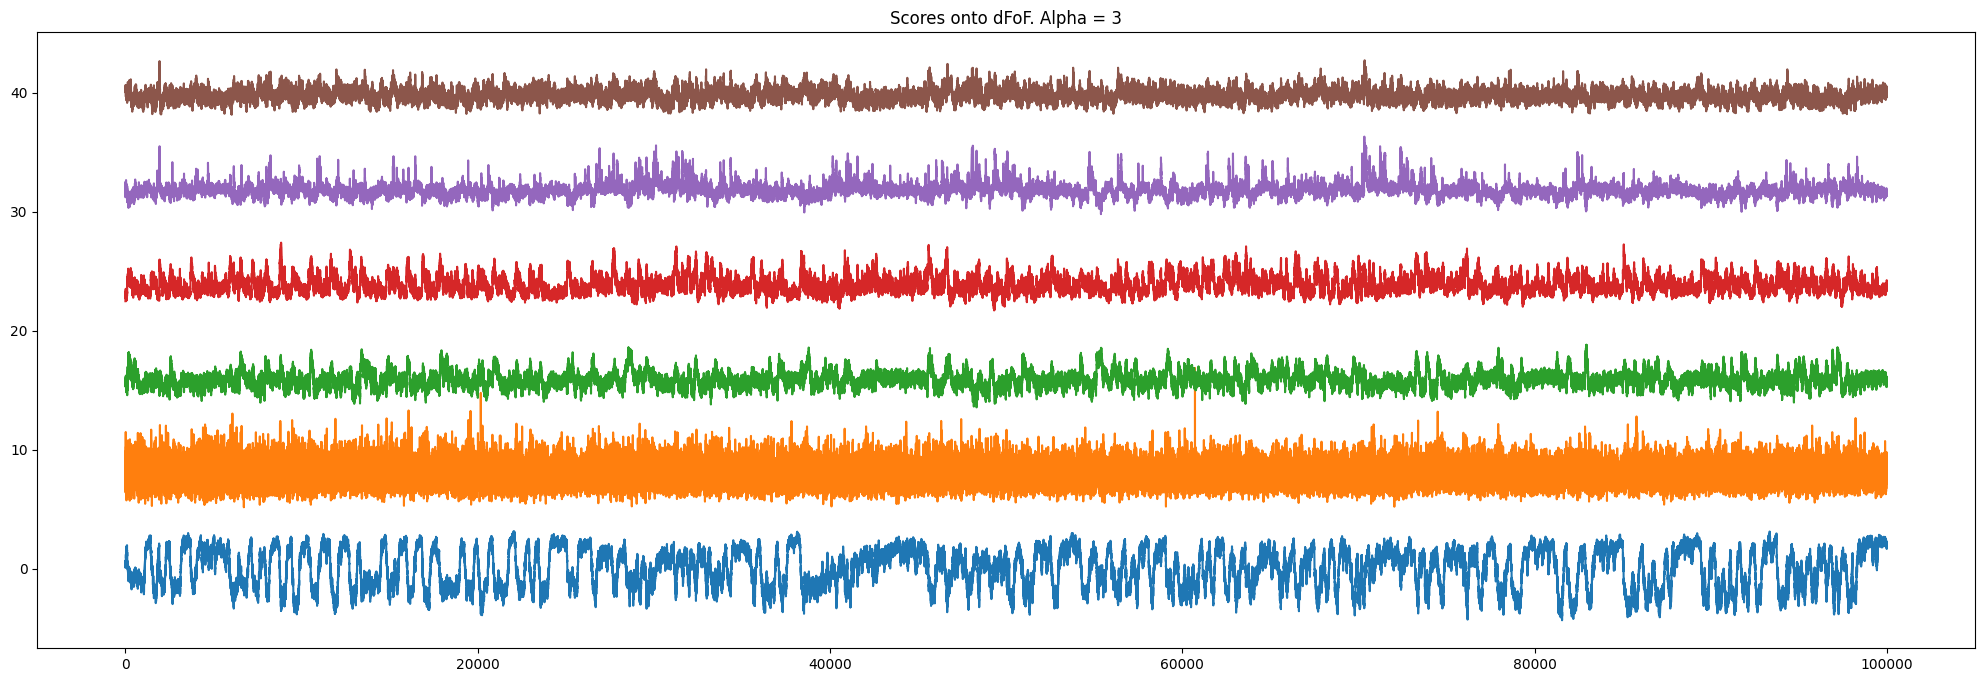

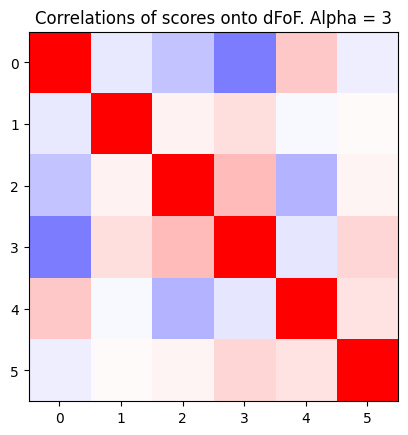

In [54]:
idx_alpha_toShow = 0

plt.figure(figsize=(25,8))
plt.plot(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF_centered.T) + np.arange(params['rank_goal'])*10*spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF_centered.T).std(1).mean());
plt.title(f"Scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

plt.figure()
plt.imshow(np.corrcoef(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF_centered.T).T), cmap='bwr', vmin=-1, vmax=1);
plt.title(f"Correlations of scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

In [55]:
print(f"Running final SPCA at a lower tolerance with alpha={alpha_toUse}")
tic = time.time()

spca = spca_partials(alpha=alpha_toUse, tol=params['spca']['tol_final'])
scores = spca.fit_transform(neural_data_toUse.T)

print(f"Duration: {time.time() - tic:.2f}s")

Running final SPCA at a lower tolerance with alpha=3
[dict_learning] ...................................................................................
Duration: 40.23s


In [56]:
results['spca'] = {}

results['spca']['alpha_toUse'] = alpha_toUse
results['spca']['objs_alphaSweep'] = {alpha: spca.__dict__ for alpha,spca in spcas.items()}
results['spca']['spca_obj'] = copy.deepcopy(spca.__dict__)
results['spca']['num_nonzero_neurons'] = (spca.components_ != 0).sum(1)

In [57]:
print(f'Number of nonzero components for neuron loadings:')
print(f"Mean: {results['spca']['num_nonzero_neurons'].mean() :.1f}")
print(f"Components: {results['spca']['num_nonzero_neurons']}")

Number of nonzero components for neuron loadings:
Mean: 86.3
Components: [203   5  94  82  91  43]


In [94]:
results['spca']['inclusionBool_factors_above_min_neurons'] = params['spca']['n_neurons_nonZero_min'] < (spca.components_ != 0).sum(1)
results['spca']['n_factors_included'] = results['spca']['inclusionBool_factors_above_min_neurons'].sum()

In [96]:
print('idx of components being EXCLUDED due to low number of nonzero neurons:')
print(f"{np.where(~results['spca']['inclusionBool_factors_above_min_neurons'])[0]}")
print(f'num factors included:')
print(f"{results['spca']['n_factors_included']}")

idx of components being EXCLUDED due to low number of nonzero neurons:
[1]
num factors included:
5


<IPython.core.display.Javascript object>


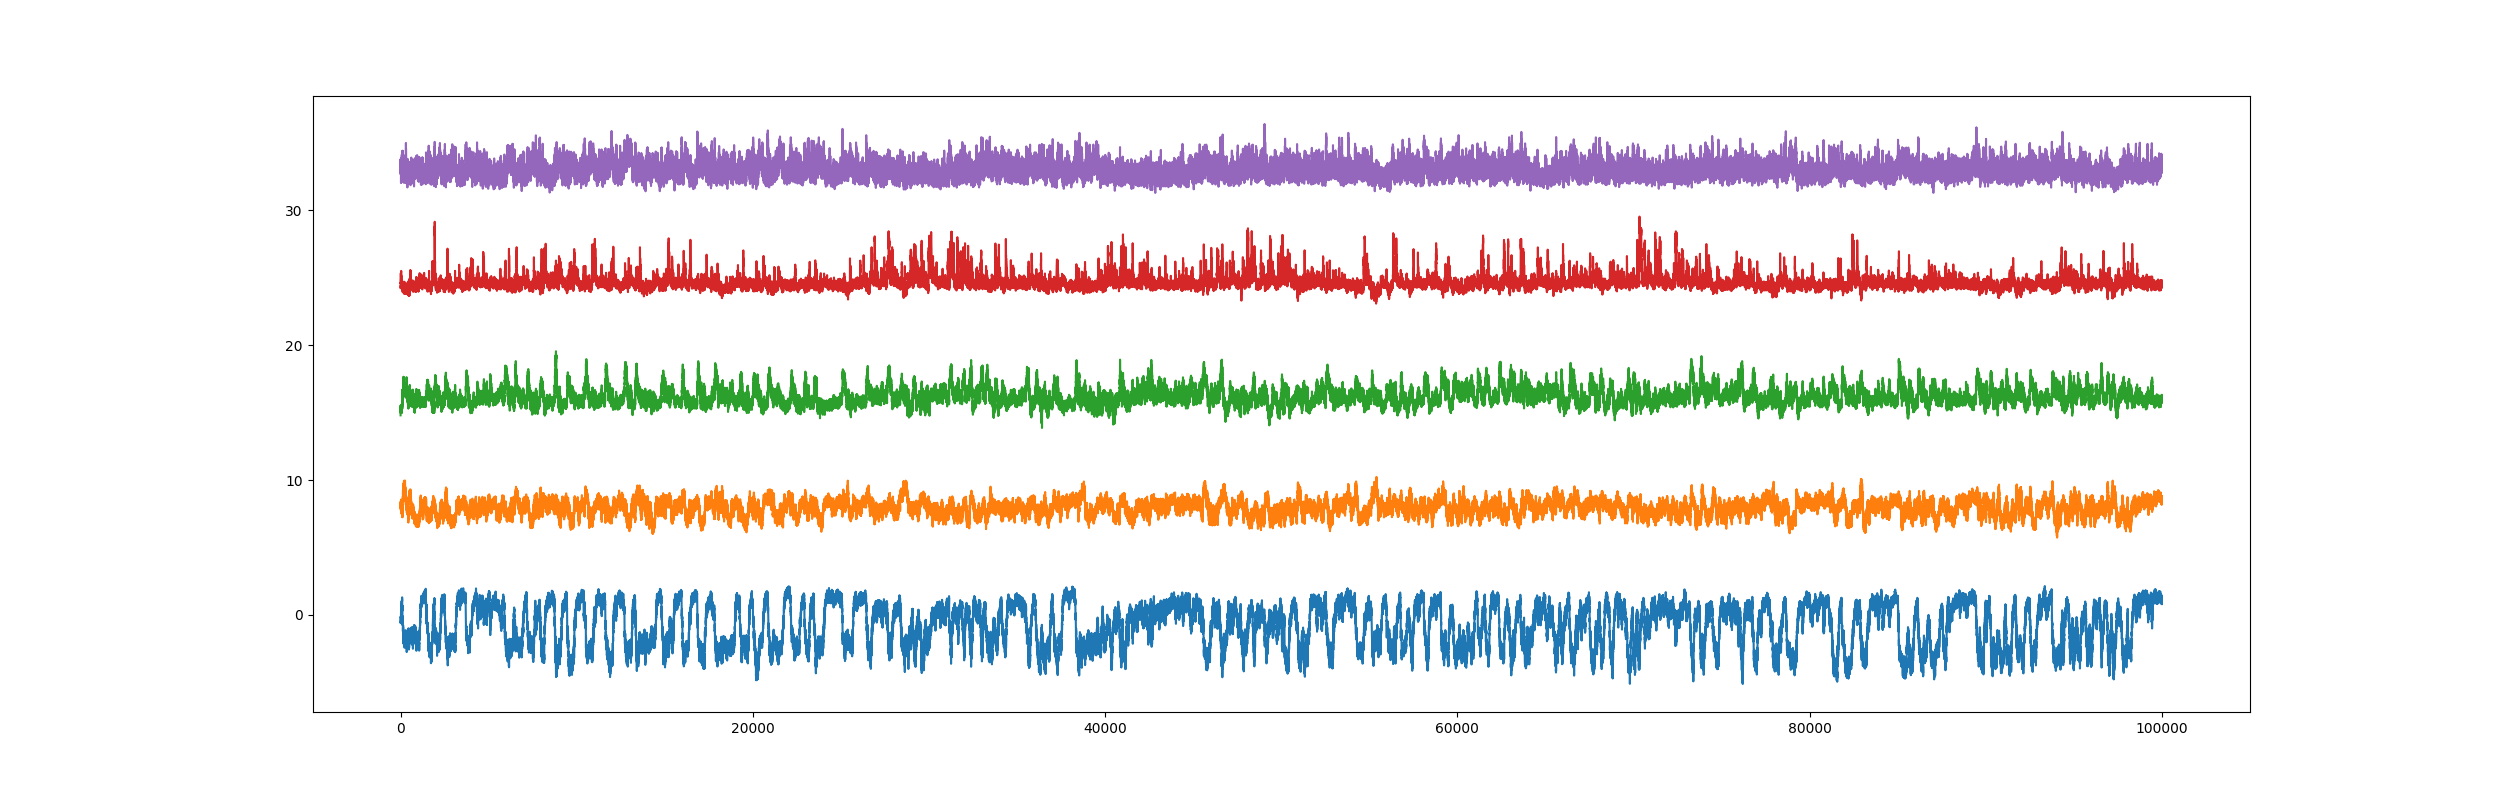

<IPython.core.display.Javascript object>


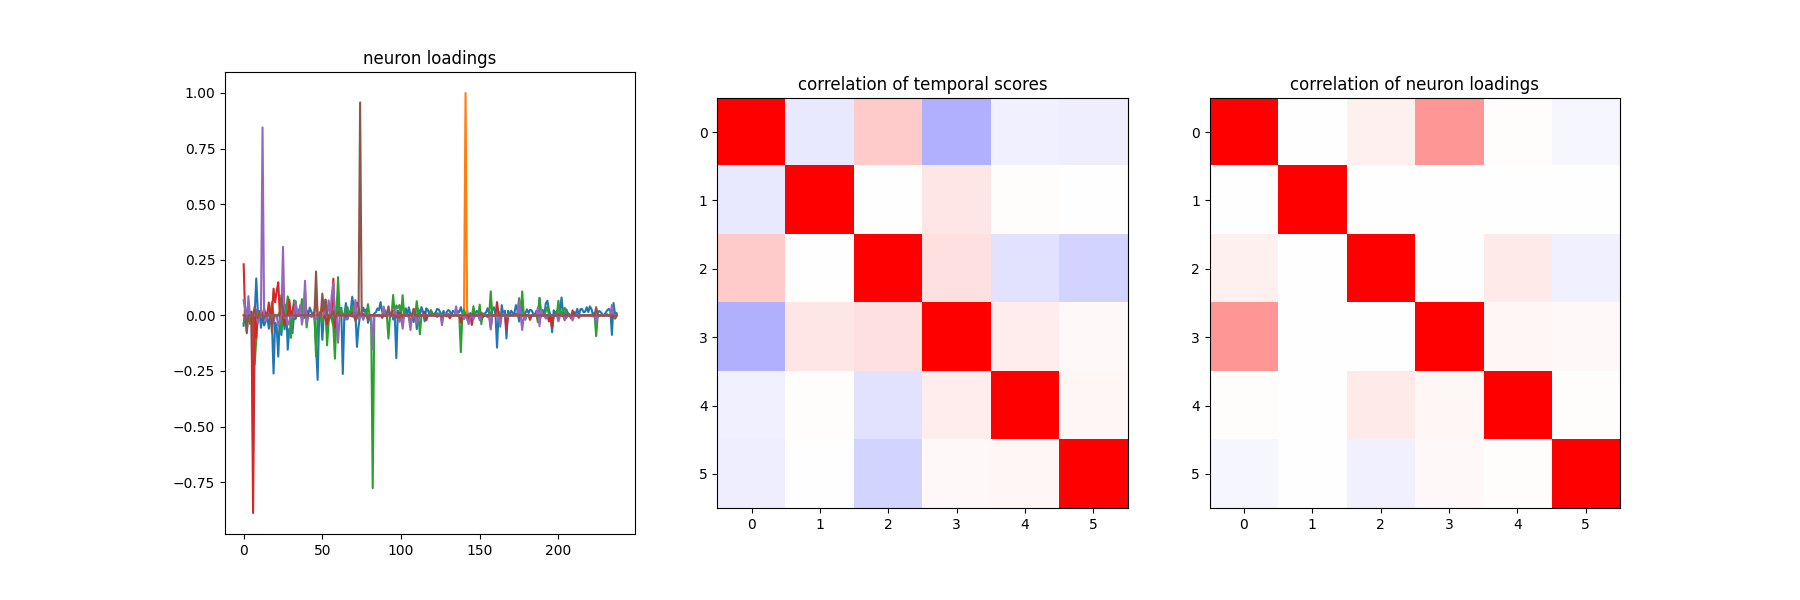

Text(0.5, 1.0, 'correlation of neuron loadings')

In [105]:
%matplotlib notebook

plt.figure(figsize=(25,8))
plt.plot(spca.transform(dFoF.T)[:, results['spca']['inclusionBool_factors_above_min_neurons']] + np.arange(results['spca']['n_factors_included'])*10*(spca.transform(dFoF.T)[:, results['spca']['inclusionBool_factors_above_min_neurons']]).std(1).mean());

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(results['spca']['spca_obj']['components_'].T);
axs[0].set_title('neuron loadings')
axs[1].imshow(np.corrcoef(scores.T), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title('correlation of temporal scores')
axs[2].imshow(np.corrcoef(results['spca']['spca_obj']['components_']), cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('correlation of neuron loadings')

<IPython.core.display.Javascript object>


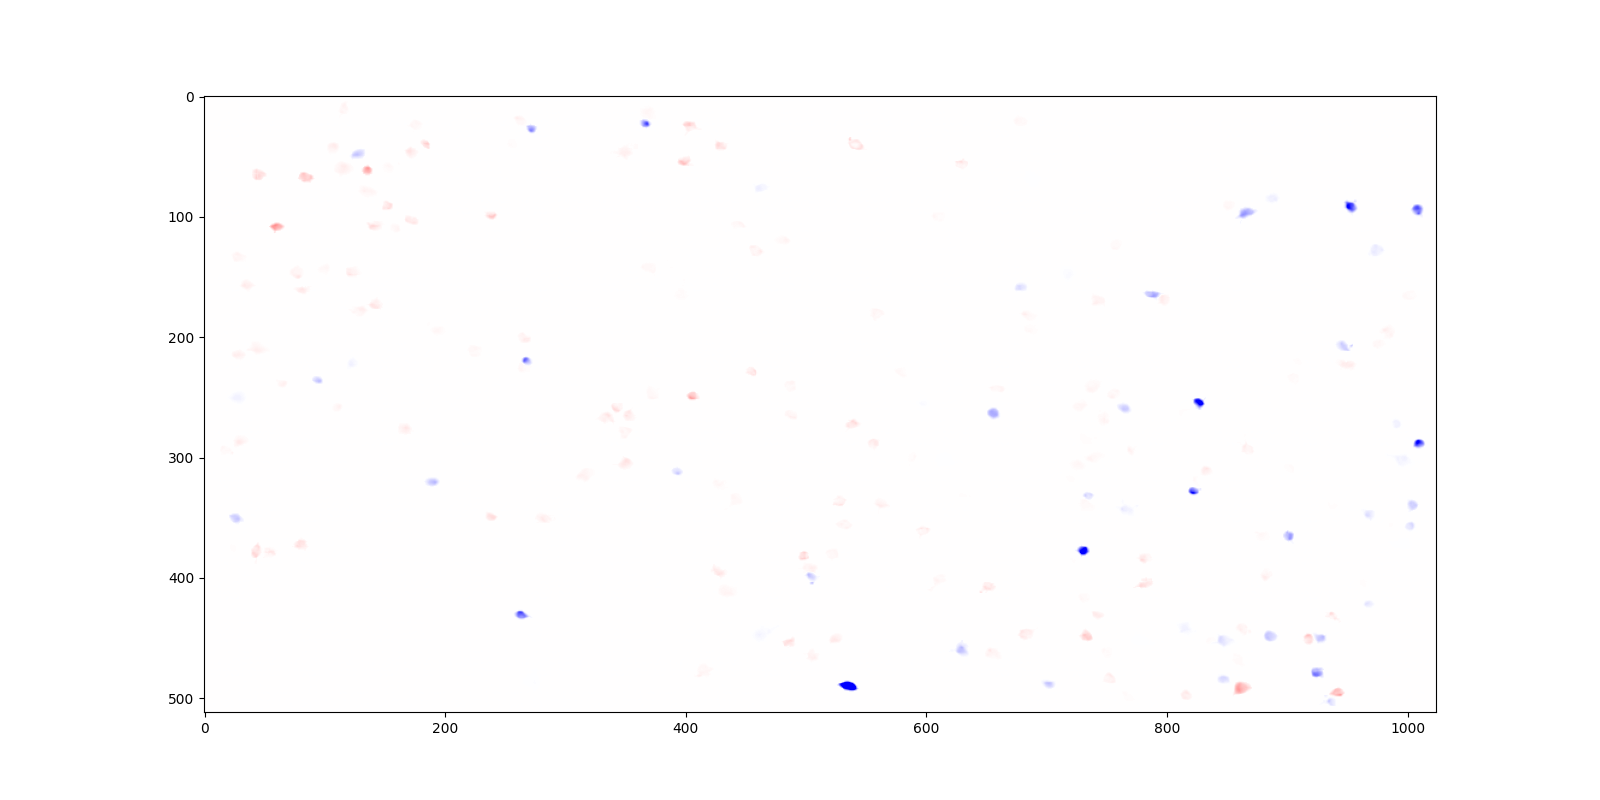

interactive(children=(IntSlider(value=0, description='i_frame', max=4), Output()), _dom_classes=('widget-inter…

In [111]:
weights = results['spca']['spca_obj']['components_'][results['spca']['inclusionBool_factors_above_min_neurons']].copy()
sf_tmp = results['ROIs']['spatial_footprints_matched']
                     
sf_weights = (sf_tmp.T * weights.T).T.reshape(results['spca']['n_factors_included'], frame_height, frame_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

In [112]:
neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

In [114]:
factors_original = results['spca']['spca_obj']['components_'][results['spca']['inclusionBool_factors_above_min_neurons']].copy()  ## shape (n_components, n_neurons)

In [115]:
scores_original = (neural_data_toUse.T @ factors_original.T).T  ## shape (n_components, n_timepoints)

In [116]:
factors_regressed, scores_regressed, bias = linear_regression.Ridge(neural_data_toUse.T, scores_original.T, lam=1*10**7, add_bias_terms=True)
factors_regressed = factors_regressed.T
scores_regressed = scores_regressed.T

In [117]:
factors_orth = bmi_idap.helpers.orthogonalize_matrix(factors_regressed)  ## shape (n_components, n_neurons)

In [118]:
scores_orth = (neural_data_toUse.T @ factors_orth.T).T  ## shape (n_components, n_timepoints)

In [119]:
factors_orth_ms = factors_orth - factors_orth.mean(1, keepdims=True)  ## shape (n_components, n_neurons)

In [120]:
factors_orth_ms_norm = factors_orth_ms / np.linalg.norm(factors_orth_ms, axis=1, keepdims=True)  ## shape (n_components, n_neurons)
scores_orth_ms_norm_raw = (dFoF.T @ factors_orth_ms_norm.T).T  ## shape (n_components, n_timepoints)

In [121]:
factors_orth_ms_norm_flipped = factors_orth_ms_norm * np.sign(scipy.stats.skew(scores_orth_ms_norm_raw, axis=1))[:,None]
scores_orth_ms_norm_flipped_raw = (dFoF.T @ factors_orth_ms_norm_flipped.T).T  ## shape (n_components, n_timepoints)

In [122]:
_, order, EVR = bmi_idap.helpers.order_factors_by_EVR(dFoF_centered, factors_orth_ms_norm_flipped, device=device)  

In [123]:
factors_orth_ms_norm_flipped_ordered = factors_orth_ms_norm_flipped[order]
scores_orth_ms_norm_flipped_ordered_raw = (neural_data_toUse.T @ factors_orth_ms_norm_flipped_ordered.T).T  ## shape (n_components, n_timepoints)

In [124]:
factors_final = factors_orth_ms_norm_flipped_ordered.copy()
scores_final = (dFoF.T @ factors_final.T).T  ## shape (n_components, n_timepoints)

In [125]:
results['factors'] = {}

results['factors']['factors_original'] = factors_original
results['factors']['factors_regressed'] = factors_regressed
results['factors']['factors_orth'] = factors_orth
results['factors']['factors_orth_ms'] = factors_orth_ms
results['factors']['factors_orth_ms_norm'] = factors_orth_ms_norm
results['factors']['factors_orth_ms_norm_flipped'] = factors_orth_ms_norm_flipped
results['factors']['factors_orth_ms_norm_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['factors_final'] = factors_final

results['factors']['scores_original'] = scores_original
results['factors']['scores_regressed'] = scores_regressed
results['factors']['scores_orth'] = scores_orth
results['factors']['scores_orth_ms_norm_raw'] = scores_orth_ms_norm_raw
results['factors']['scores_orth_ms_norm_flipped_raw'] = scores_orth_ms_norm_flipped_raw
results['factors']['scores_orth_ms_norm_raw_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['scores_final'] = scores_final


<IPython.core.display.Javascript object>


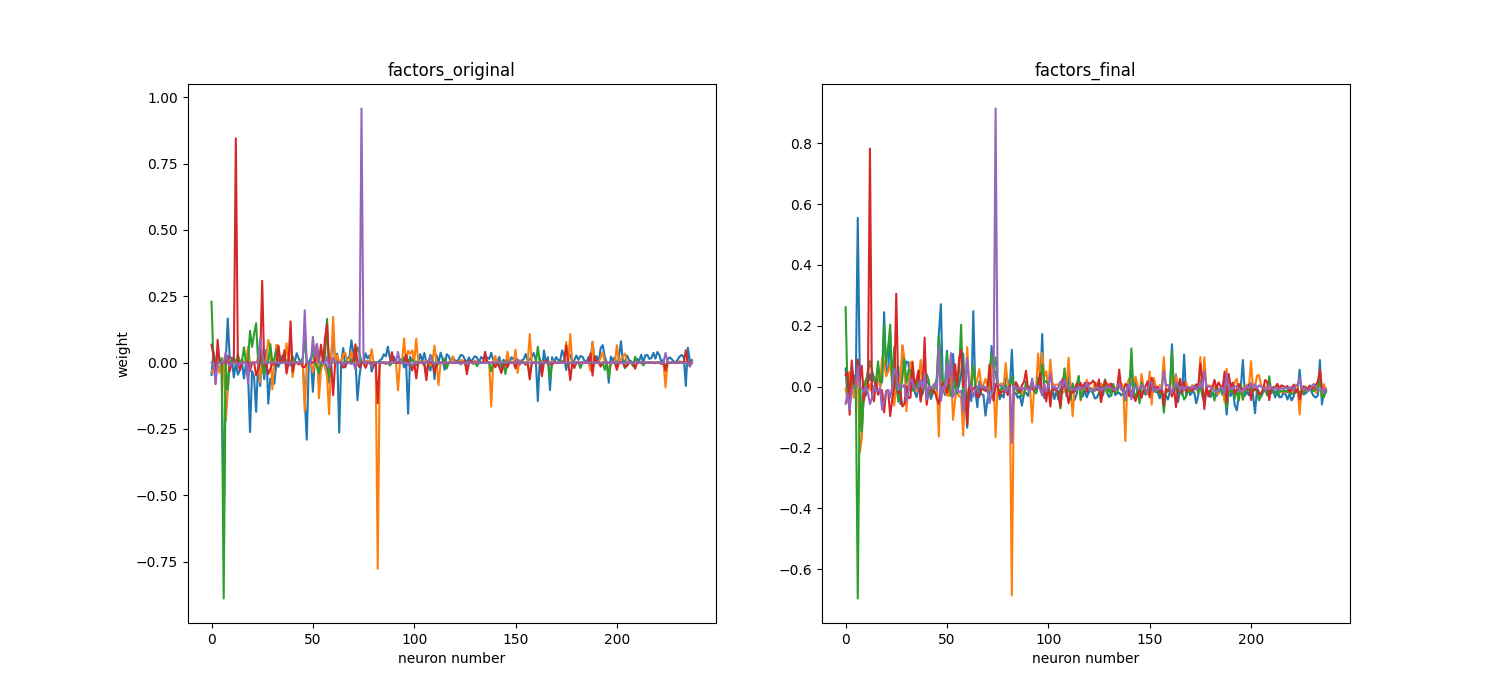

In [126]:
%matplotlib notebook
fig, axs = plt.subplots(1,2, figsize=(15, 7), sharex=True)
axs[0].plot(factors_original.T)
axs[0].set_ylabel('weight')
axs[0].set_xlabel('neuron number')
axs[0].set_title('factors_original')
axs[1].plot(factors_final.T)
axs[1].set_xlabel('neuron number')
axs[1].set_title('factors_final');

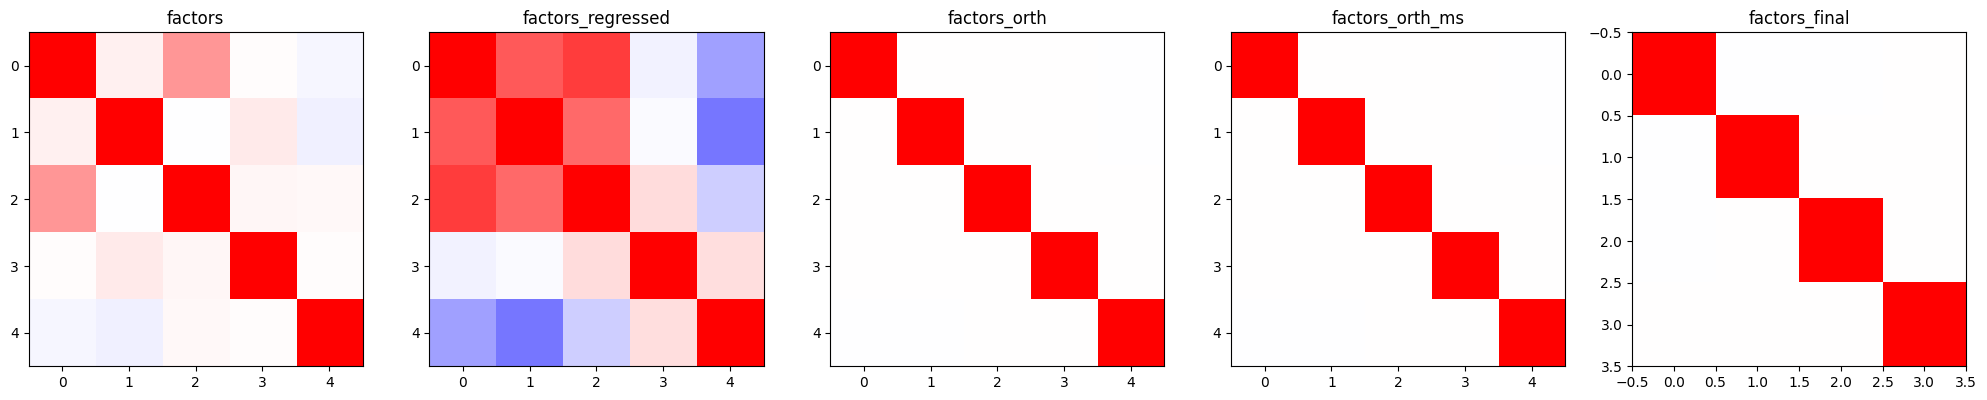

In [128]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(25,5))
axs[0].imshow(np.corrcoef(factors_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('factors')
axs[1].imshow(np.corrcoef(factors_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('factors_regressed')
axs[2].imshow(np.corrcoef(factors_orth), cmap='bwr', clim=[-1,1])
axs[2].set_title('factors_orth')
axs[3].imshow(np.corrcoef(factors_orth_ms), cmap='bwr', clim=[-1,1])
axs[3].set_title('factors_orth_ms')
axs[4].imshow(np.corrcoef(factors_final[:-1]), cmap='bwr', clim=[-1,1])
axs[4].set_title('factors_final');

Text(0.5, 1.0, 'scores_final')

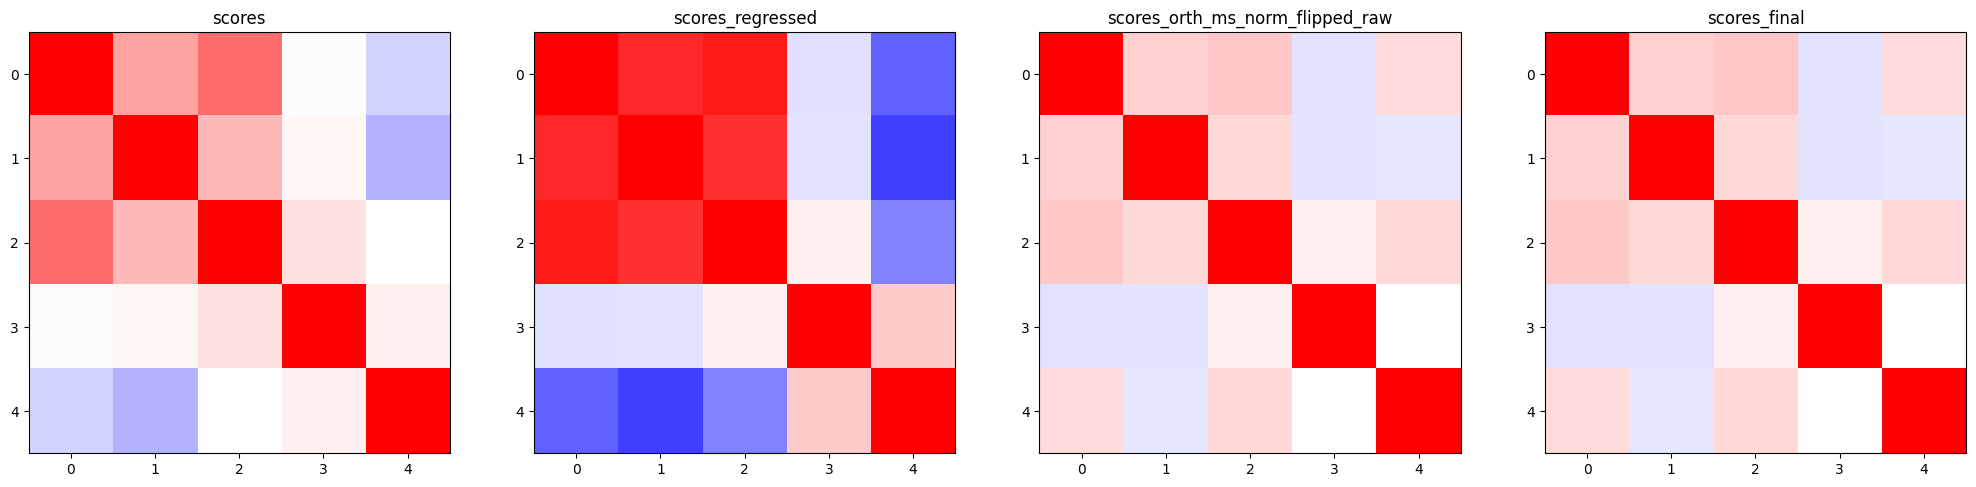

In [129]:
fig, axs = plt.subplots(1, 4, figsize=(25,6))
axs[0].imshow(np.corrcoef(scores_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('scores')
axs[1].imshow(np.corrcoef(scores_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('scores_regressed')
axs[2].imshow(np.corrcoef(scores_orth_ms_norm_flipped_raw), cmap='bwr', clim=[-1,1])
axs[2].set_title('scores_orth_ms_norm_flipped_raw')
axs[3].imshow(np.corrcoef(scores_final), cmap='bwr', clim=[-1,1])
axs[3].set_title('scores_final')


Text(0.5, 1.0, 'scores_final')

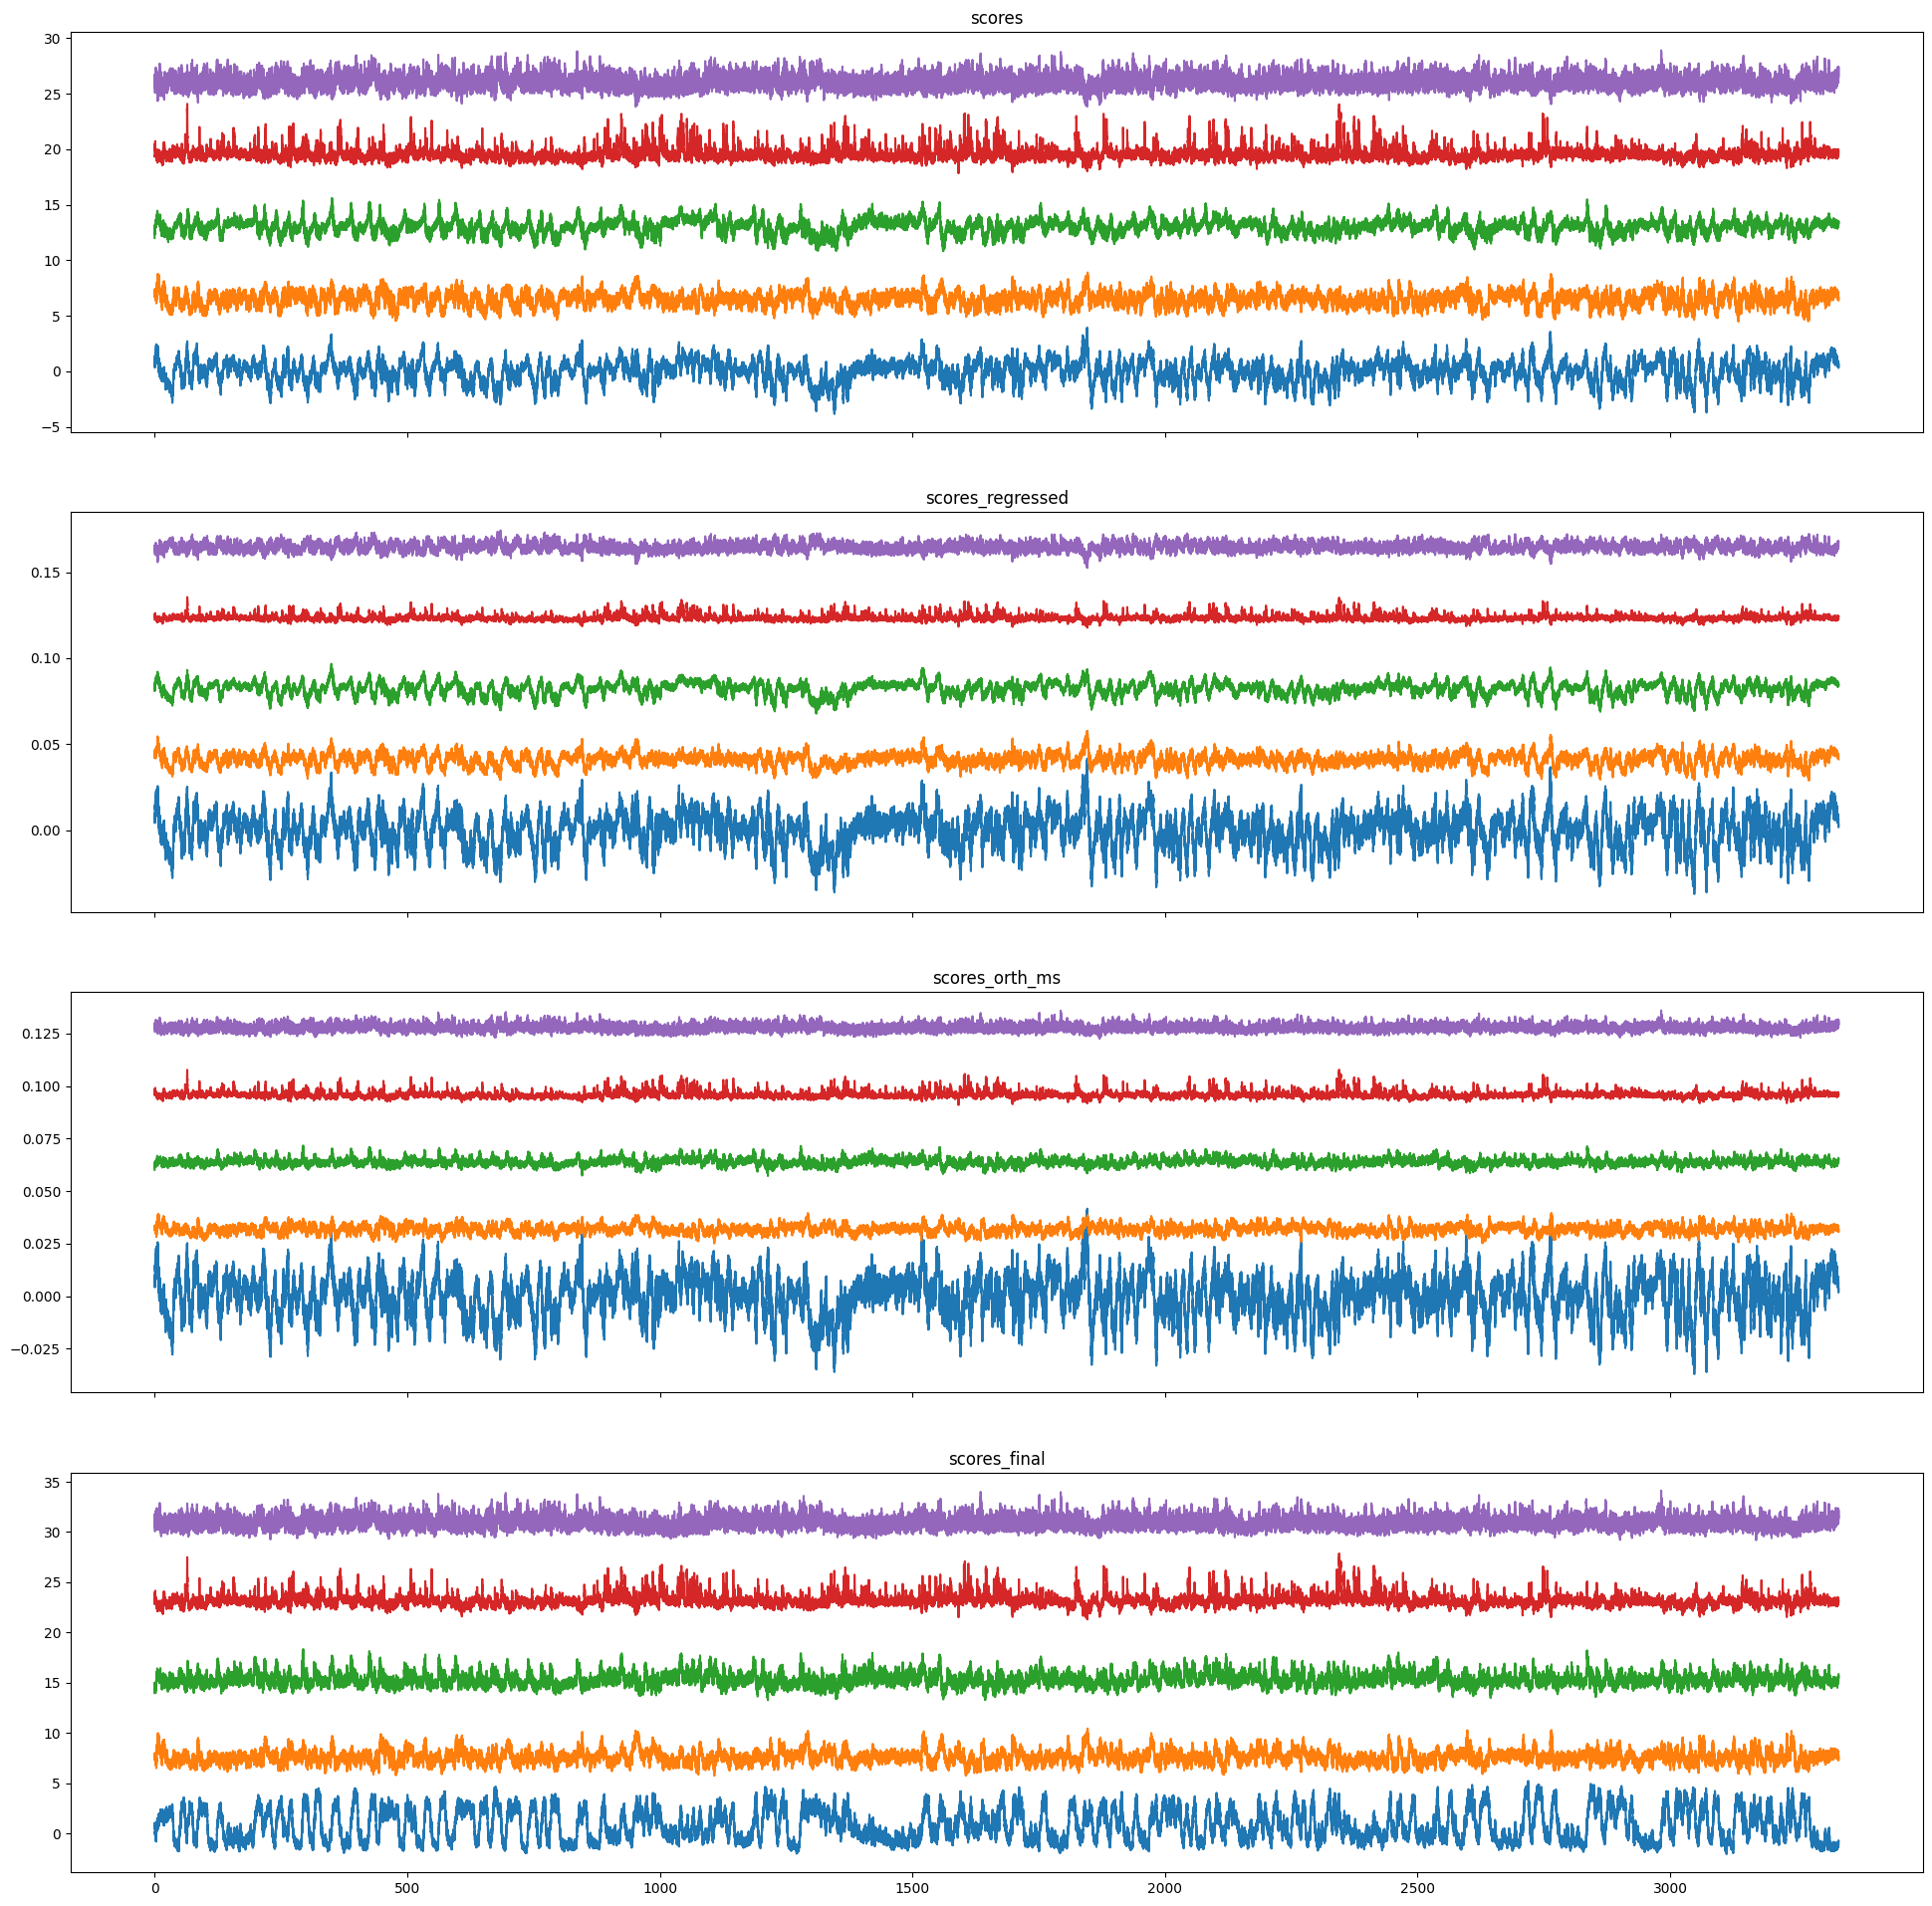

In [131]:
fig, axs = plt.subplots(4, 1, figsize=(24,24), sharex=True)
axs[0].plot(np.arange(scores_original.shape[1])/Fs,  scores_original.T + 10*scores_original.std(1).mean()*np.arange(results['spca']['n_factors_included'])[None,:]);
axs[0].set_title('scores')
axs[1].plot(np.arange(scores_original.shape[1])/Fs,  scores_regressed.T + 10*scores_regressed.std(1).mean()*np.arange(results['spca']['n_factors_included'])[None,:]);
axs[1].set_title('scores_regressed')
axs[2].plot(np.arange(scores_original.shape[1])/Fs,  scores_orth.T + 10*scores_orth.std(1).mean()*np.arange(results['spca']['n_factors_included'])[None,:]);
axs[2].set_title('scores_orth_ms')
axs[3].plot(np.arange(scores_original.shape[1])/Fs,  scores_final.T + 10*scores_final.std(1).mean()*(np.arange(results['spca']['n_factors_included']))[None,:]);
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>


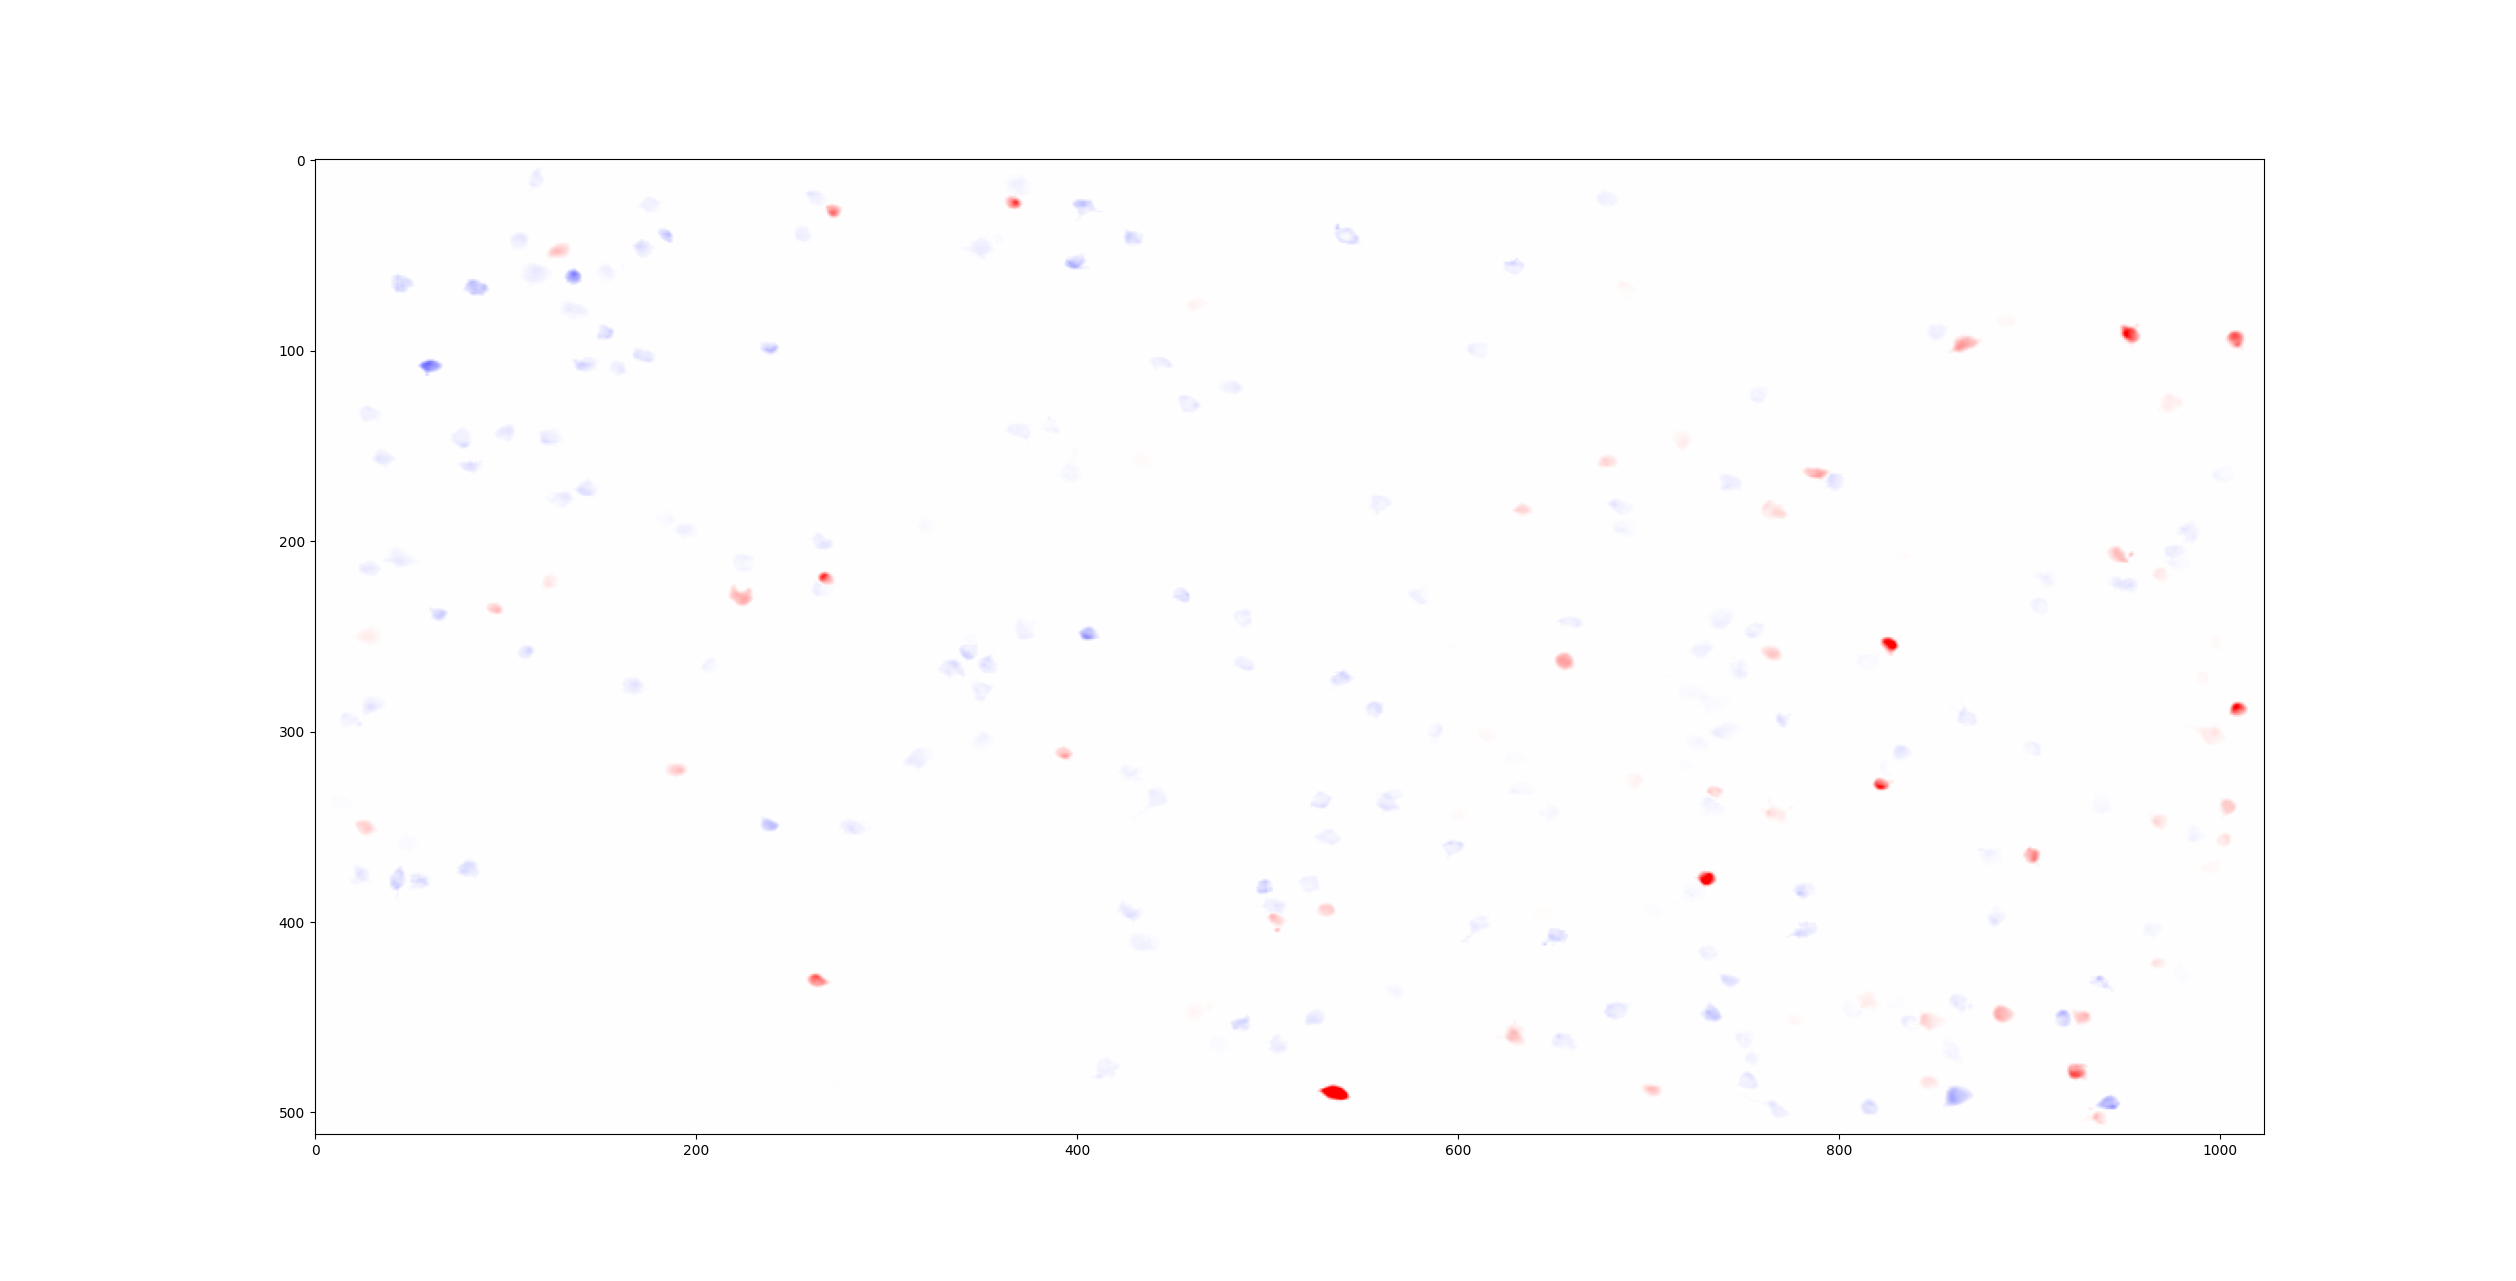

interactive(children=(IntSlider(value=0, description='i_frame', max=4), Output()), _dom_classes=('widget-inter…

In [192]:
weights = factors_final.copy()
sf_tmp = results['ROIs']['spatial_footprints_matched']
                     
sf_weights = (sf_tmp.T * weights.T).T.reshape(results['spca']['n_factors_included'], frame_height, frame_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

In [133]:
factors_final.shape

(5, 238)

<IPython.core.display.Javascript object>


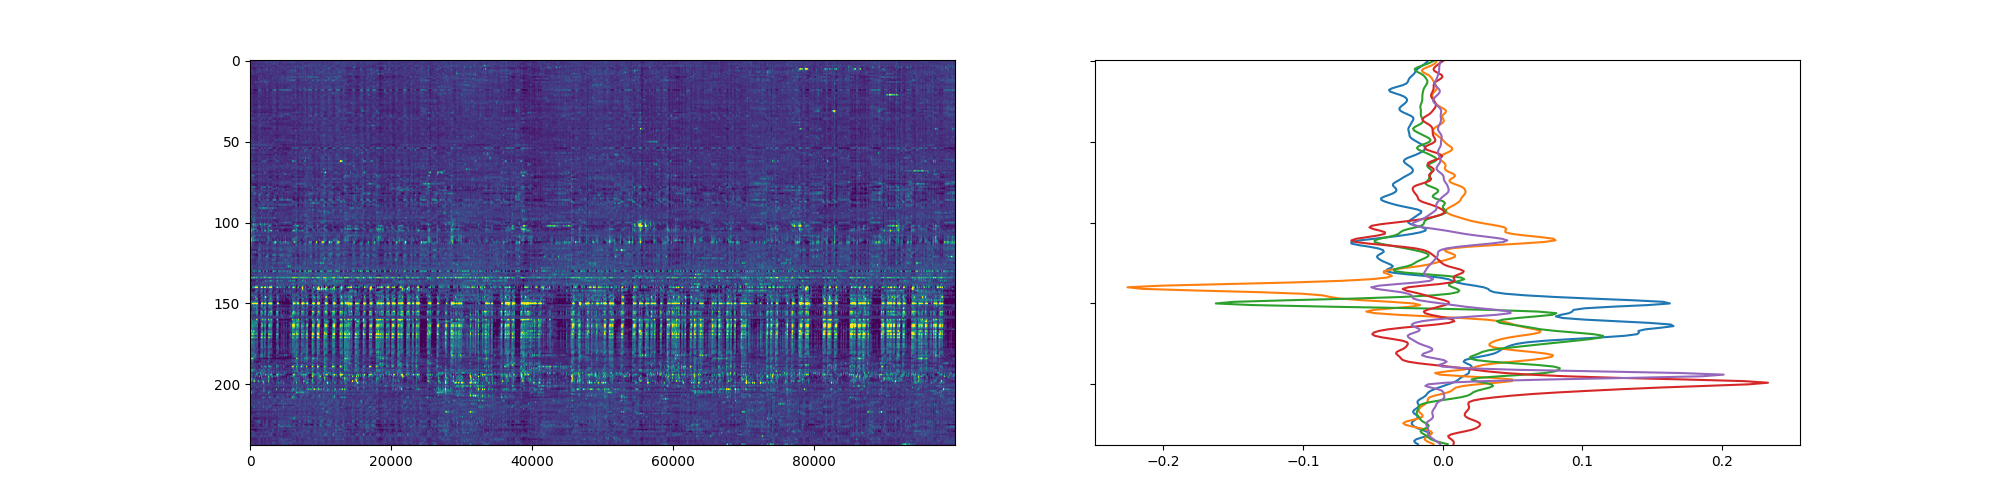

In [134]:
fig, axs = plt.subplots(1,2, figsize=(20,5), sharey=True)
axs[0].imshow(dFoF[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)
axs[1].plot(timeSeries.simple_smooth(factors_final[:,rmap.isort].T, sig=3, axis=0), np.arange(factors_final.shape[1]));

In [135]:
def make_evr_power_curve(factors, data, powers=[0, 1, 2, 3, 5, 10], device='cpu'):
    decoder = bmi_idap.decoder.Decoder_angle_magnitude(
        F=factors.T,
        device=device
    )
    
    Ds = [decoder(X=data, power=p)[0] for p in powers]
    
    evrs = [similarity.orthogonalize(data.T, d.T, device=device, method='OLS')[2] for d in tqdm(Ds)]
    
    return evrs

In [136]:
components_pca, scores_pca, singVals_pca, EVR_pca = decomposition.torch_pca(neural_data_toUse.T, mean_sub=True, device=device, return_numpy=True)

In [137]:
vals_power = np.concatenate([[0], math_functions.bounded_logspace(0.1, 100, 30)])

# evrs = [make_evr_power_curve(f, neural_data_toUse, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_orth_ms_ordered_norm]]
evrs = [make_evr_power_curve(f, dFoF, powers=vals_power, device=device) for f in [components_pca.T[:results['spca']['n_factors_included']], factors_final[:-1]]]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


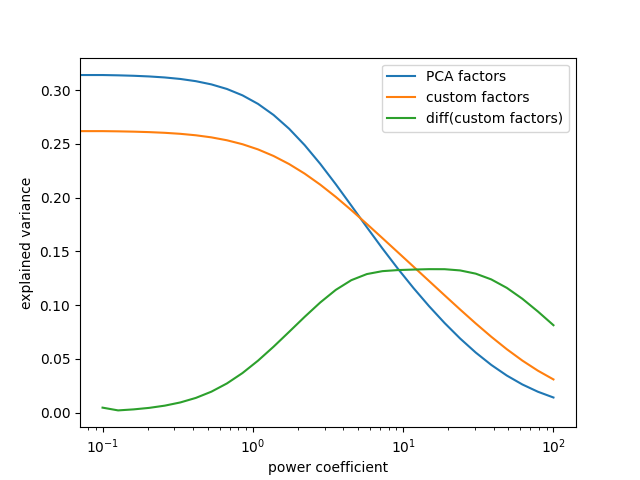

In [138]:
plt.figure()
plt.plot(vals_power, evrs[0])
plt.plot(vals_power, evrs[1])
plt.plot(vals_power[1:], np.diff(evrs[1])*-10)

plt.ylabel('explained variance')
plt.xlabel('power coefficient')
plt.xscale('log')
plt.legend(['PCA factors', 'custom factors', 'diff(custom factors)'])
# plt.ylim([0, 0.5])

In [139]:
results['manifold_alignment'] = {}

results['manifold_alignment']['components_pca'] = components_pca
results['manifold_alignment']['vals_power'] = vals_power
results['manifold_alignment']['evrs_pca'] = evrs[0]
results['manifold_alignment']['evrs_factors'] = evrs[1]

In [140]:
params['simulation'] = {}

params['simulation']['idx_factor'] = 0  ## 0-indexed
params['simulation']['power'] = 2.0
params['simulation']['thresh_reward'] = 1.5
params['simulation']['thresh_quiescence_cursorDecoder'] = 0.1 * params['simulation']['thresh_reward']
params['simulation']['thresh_quiescence_cursorMag'] = 0.1

params['simulation']['duration_quiescence_hold'] = 3
params['simulation']['duration_threshold_hold'] = 3
params['simulation']['win_smooth_cursor'] = 1

In [141]:
decoder = bmi_idap.decoder.Decoder_angle_magnitude(
    F=results['factors']['factors_final'].T,
    device=device,
    power=params['simulation']['power'],
)

D, CS, M = decoder(dFoF)

In [142]:
params['simulation']['thresh_quiescence_cursorMag'] = max([torch.quantile(M[params['simulation']['idx_factor']], q=params['simulation']['thresh_quiescence_cursorMag']).item(), 0])


In [143]:
num_rewards, sm = bmi_idap.decoder.simple_cursor_simulation(
    D.T, 
    CS.T, 
    M.T,
    idx_cursor=params['simulation']['idx_factor'], 
    thresh_reward=params['simulation']['thresh_reward'], 
    thresh_quiescence_cursorMag=params['simulation']['thresh_quiescence_cursorMag'], 
    thresh_quiescence_cursorDecoder=params['simulation']['thresh_quiescence_cursorDecoder'], 
    duration_quiescence_hold=params['simulation']['duration_quiescence_hold'],
    duration_threshold_hold=params['simulation']['duration_threshold_hold'],
    win_smooth_cursor=1,
)

/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/bnpm/timeSeries.py:643: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  convolved = torch.nn.functional.conv1d(X_rshp, kernel_rshp, **conv1d_kwargs)
100%|████████████████████████████████| 100000/100000 [00:07<00:00, 12686.80it/s]


In [144]:
rewards_per_min = num_rewards / (D.shape[1] / (Fs*60*1))

print(f"Rewards per minute: {rewards_per_min :.3f}")

Rewards per minute: 1.566


<IPython.core.display.Javascript object>


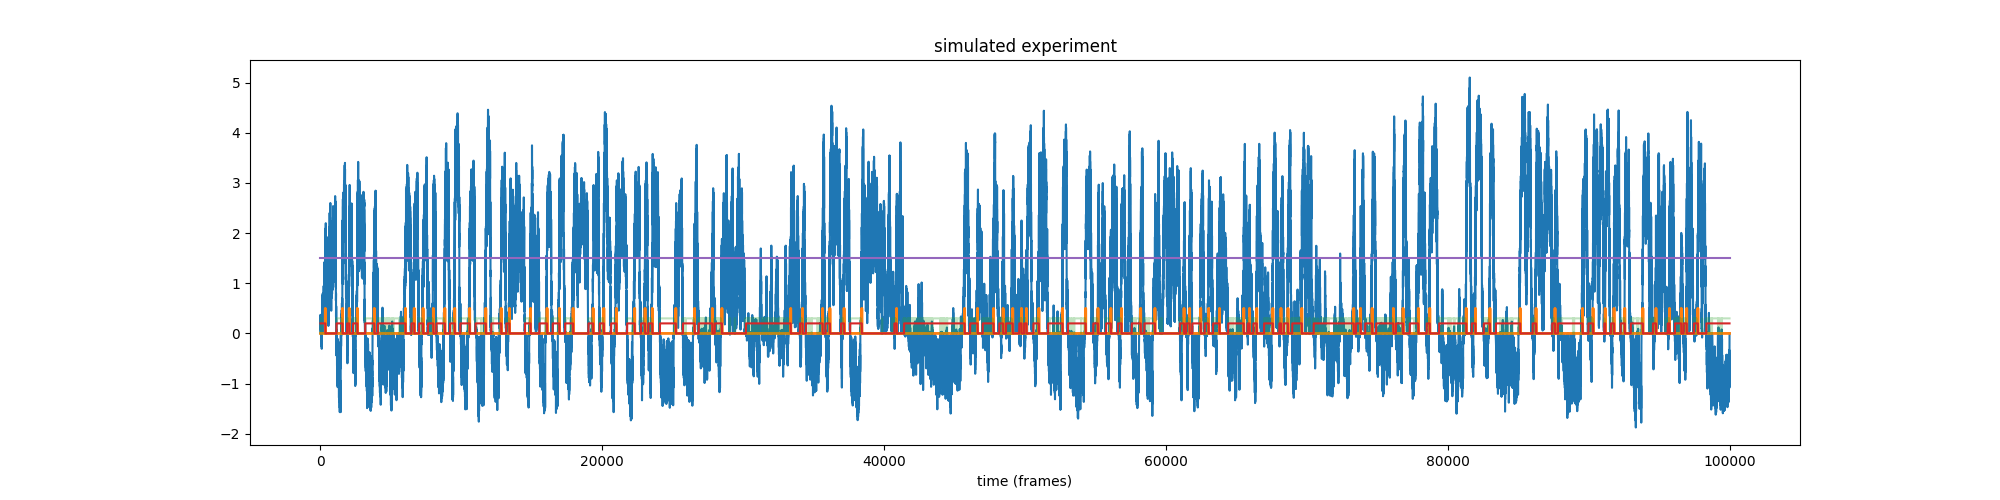

In [145]:
plt.figure(figsize=(20,5))
plt.plot(sm['cursor'])
plt.plot(sm['rewards']*0.5, linewidth=2)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.plot([0, D.shape[1]], [params['simulation']['thresh_reward'], params['simulation']['thresh_reward']])
plt.title('simulated experiment')
plt.xlabel('time (frames)');

In [146]:
results['simulation'] = {}

results['simulation']['idx_factor'] = params['simulation']['idx_factor']
results['simulation']['D'] = D
results['simulation']['CS'] = CS
results['simulation']['M'] = M
results['simulation']['num_rewards'] = num_rewards
results['simulation']['rewards_per_min'] = rewards_per_min
results['simulation']['sm'] = sm

<IPython.core.display.Javascript object>


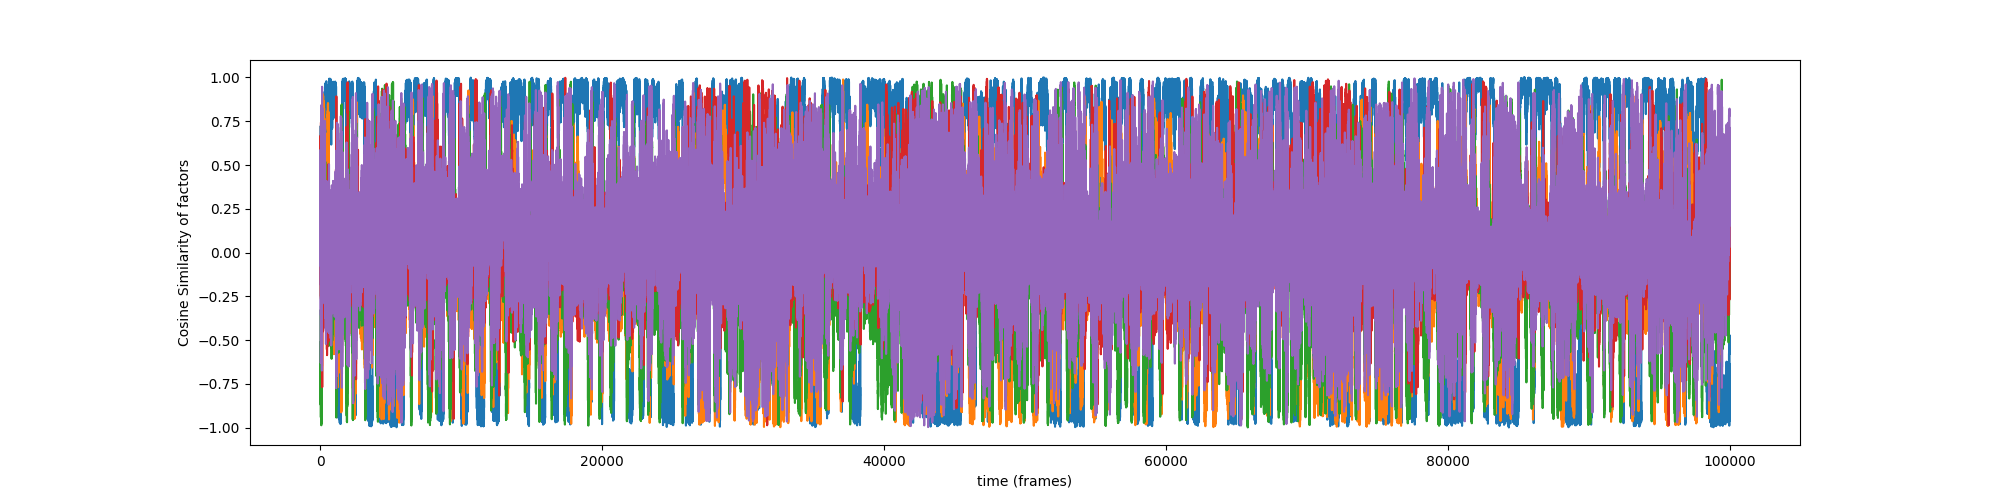

In [147]:
plt.figure(figsize=(20,5))
plt.plot(CS.T.cpu());
plt.xlabel('time (frames)')
plt.ylabel('Cosine Similarity of factors');

<IPython.core.display.Javascript object>


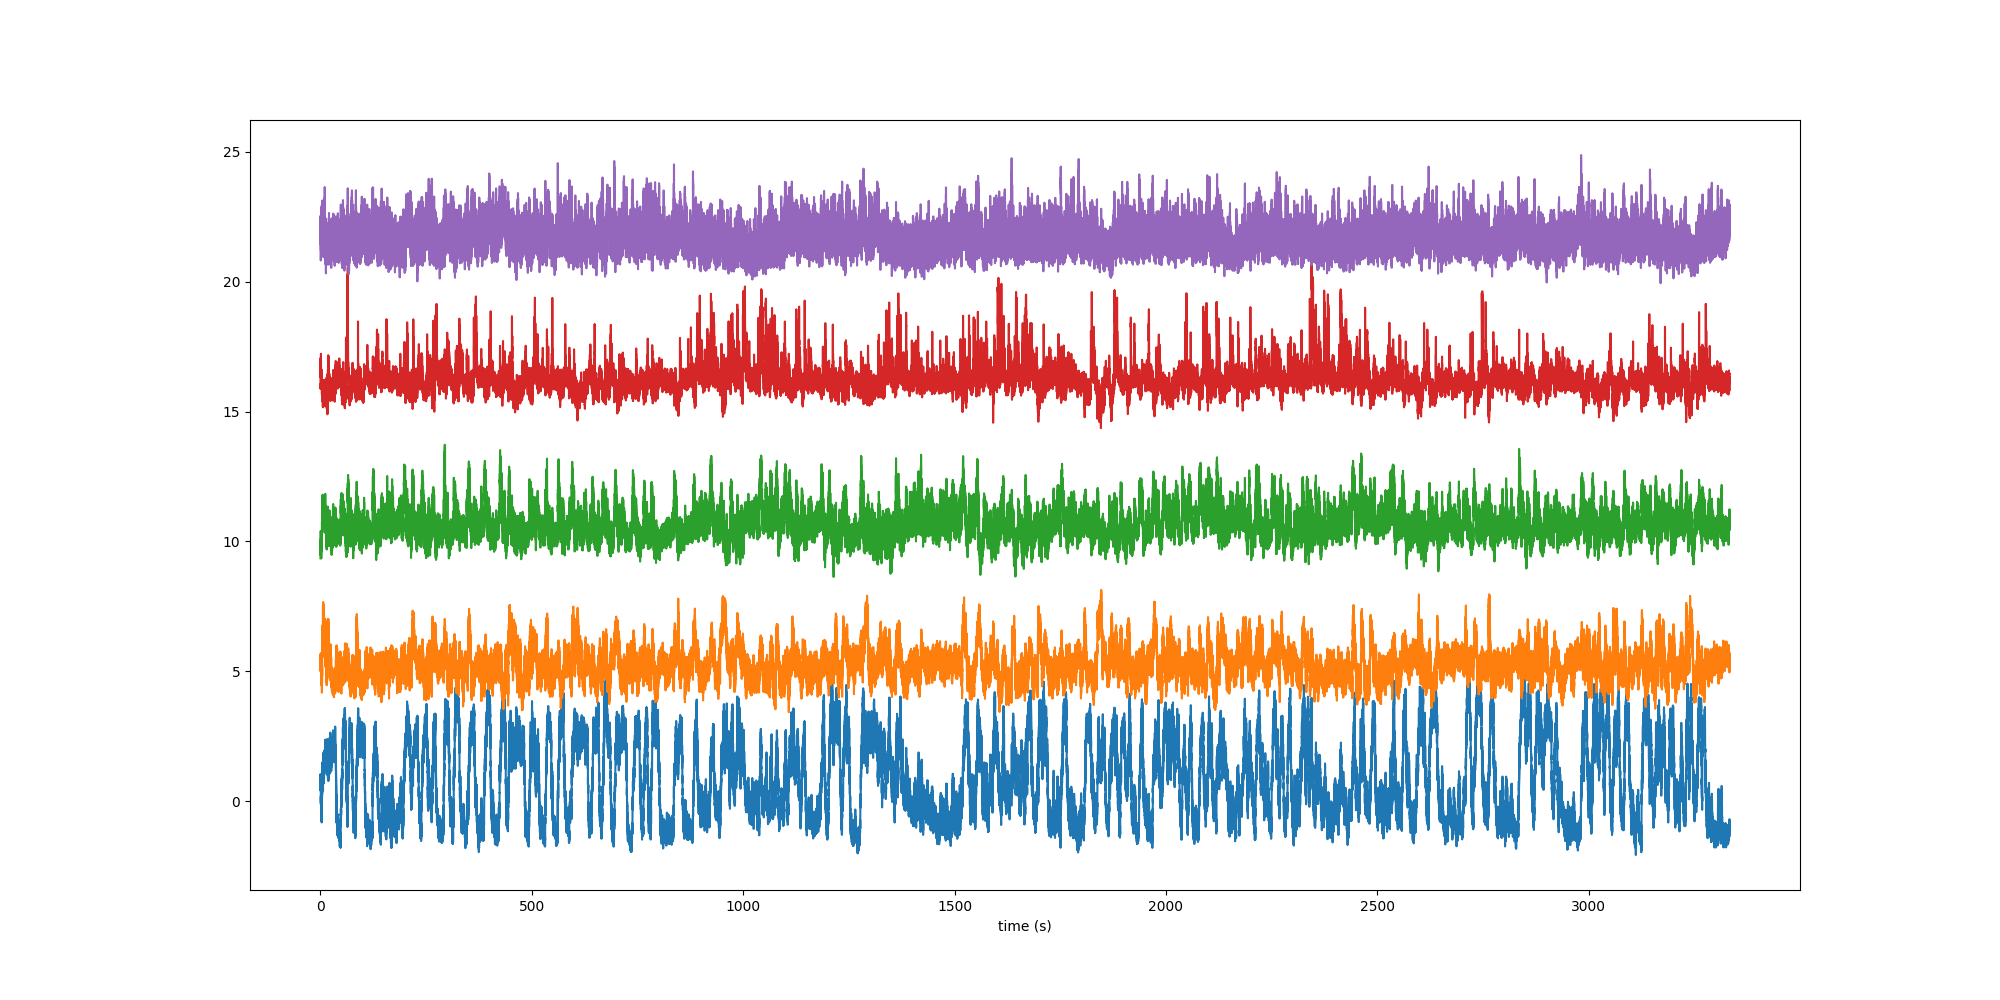

In [148]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(M.shape[1])/Fs, (M.cpu() + torch.arange(M.shape[0])[:,None]*M.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


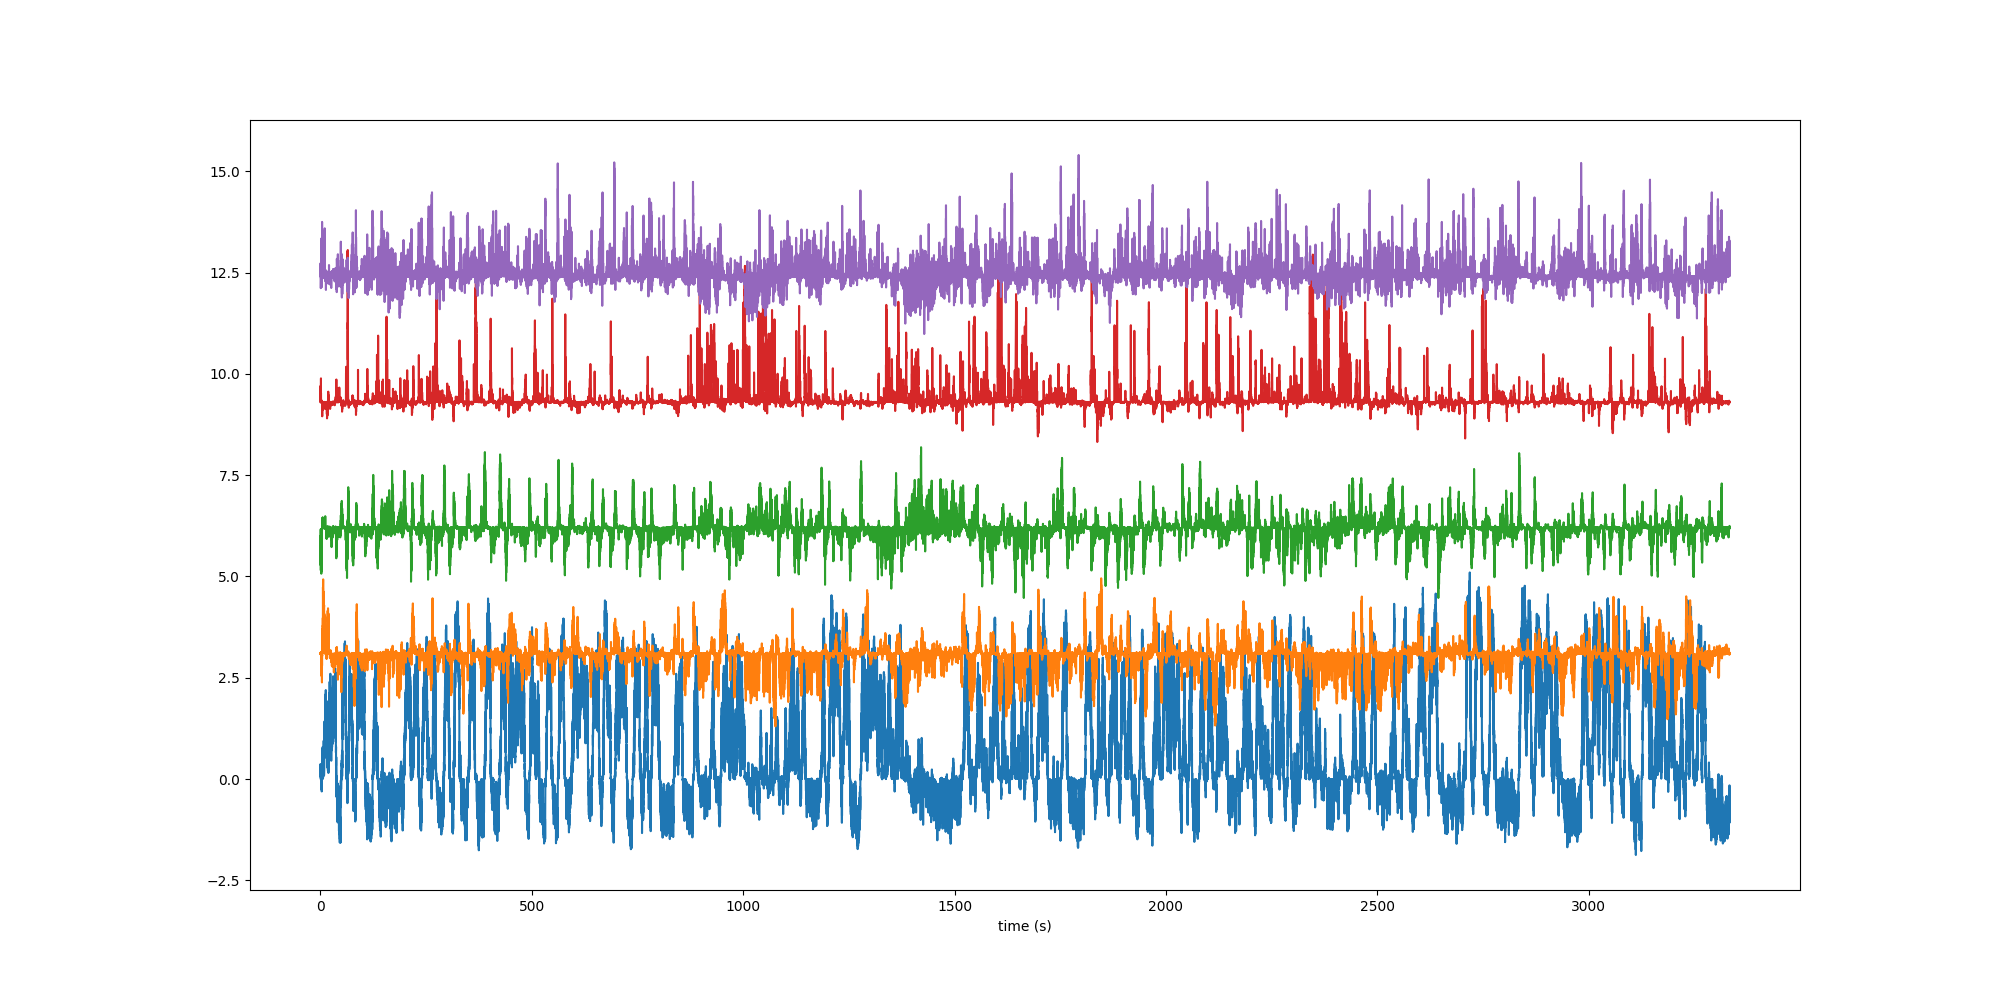

In [149]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(D.shape[1])/Fs, (D.cpu() + torch.arange(D.shape[0])[:,None]*D.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


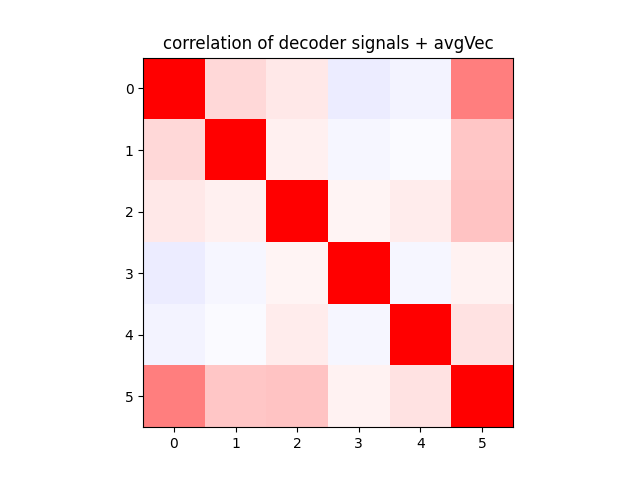

In [152]:
plt.figure()
plt.imshow(
    np.corrcoef(np.concatenate(
        (D.cpu(), dFoF.mean(0)[None,:]), axis=0   
    )), vmin=-1, vmax=1, cmap='bwr'
);
plt.title('correlation of decoder signals + avgVec');

In [159]:
directions = np.arange(results['spca']['n_factors_included']) * (360 / results['spca']['n_factors_included'])

In [160]:
x, y = np.cos(np.deg2rad(directions)), np.sin(np.deg2rad(directions))
xy = np.stack((x,y), axis=1)
np.random.shuffle(xy)

In [161]:
test1 = M.T.cpu().numpy() @ xy
test2 = D.T.cpu().numpy() @ xy

In [162]:
test3 = np.einsum('ij,ik -> ikj', M.cpu().numpy(), xy)

<IPython.core.display.Javascript object>


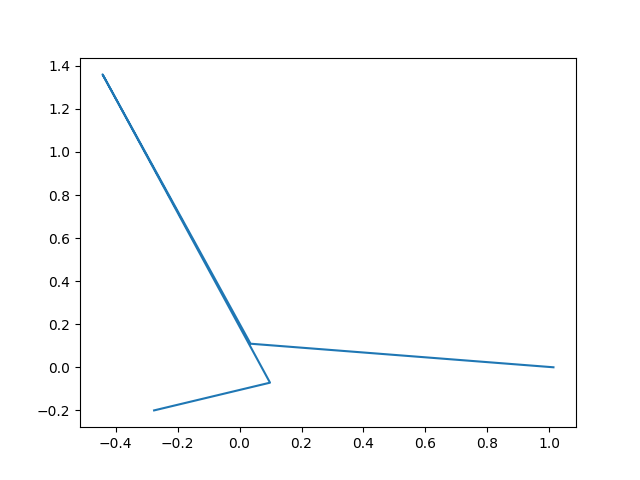

In [191]:
plt.figure()
plt.plot(test3[:,0,0], test3[:,1,0])

<IPython.core.display.Javascript object>


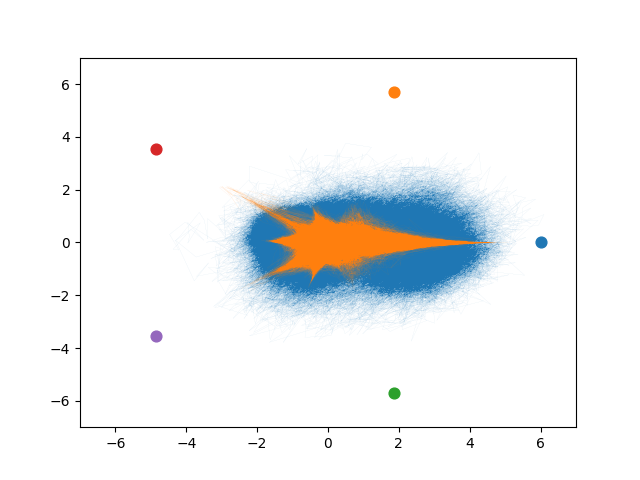

(-7.0, 7.0)

In [164]:
%matplotlib notebook

plt.figure()
[plt.scatter(xy[ii,0]*6, xy[ii,1]*6, s=60) for ii in range(len(x))]
plt.plot(test1[:,0], test1[:,1], linewidth=0.02)
plt.plot(test2[:,0], test2[:,1], linewidth=0.02)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

visualization of final traces and masks

# Save it all

In [165]:
results['ROIs'].keys()

dict_keys(['spatial_footprints_all', 'spatial_footprints_matched', 'sfneu_all', 'sfneu_matched'])

In [166]:
results.keys()

dict_keys(['general', 'device', 'ROIs', 'data', 'idx_time_bad', 'preorthogonalization', 'spca', 'factors', 'manifold_alignment', 'simulation'])

In [167]:
results['data']

{'n_rois': 238, 'Fs': 30, 'frame_height': 512, 'frame_width': 1024}

In [174]:
params

{'paths': {'dir_analysisFiles': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles',
  'dir_s2p_outer': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles',
  'path_iscell': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/iscell_classifier_matching_tqm.pkl',
  'path_tqm': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/trace_quality.pkl',
  'dir_save': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles',
  'path_save_weights': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/weights_day0',
  'path_save_results': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/decoder_definition',
  'dirs_s2p': ['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230424',
   '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230425']},
 'general': {'use_gpu': True},
 'ROIs': {'idx_session_toUse': -1,
  'path_session_toUse': '/media/rich/bigSSD/downloads_tmp/tmp_data

In [175]:
file_helpers.json_save(params, '/home/rich/Desktop/params_mouse0322R_day0_2.json')

In [181]:
results['ROIs']['spatial_footprints_matched'].tocsr().max(0)

<1x524288 sparse matrix of type '<class 'numpy.float64'>'
	with 22354 stored elements in COOrdinate format>

<IPython.core.display.Javascript object>


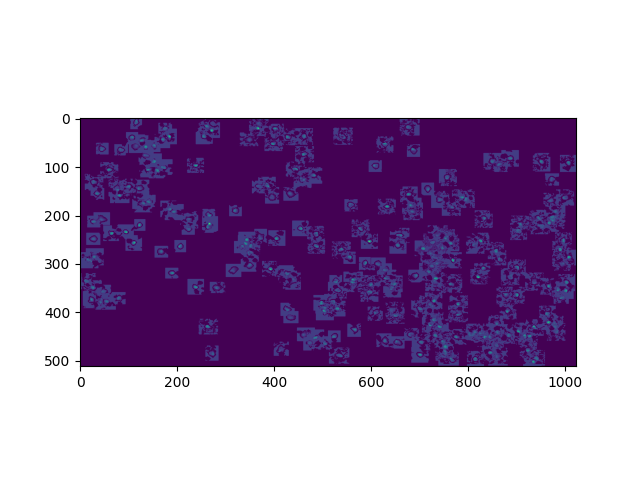

In [187]:
plt.figure()
plt.imshow(results['ROIs']['spatial_footprints_matched'].max(0).A.reshape((512,1024)) + results['ROIs']['sfneu_matched'].max(0).A.reshape((512,1024))/100)

In [188]:
sfm_coo = results['ROIs']['spatial_footprints_matched'].tocoo()
fn_coo = results['ROIs']['sfneu_matched'].tocoo()

weights_day0 = {
    "factors" : results['factors']['factors_final'],
#     "iscell_custom": results['data']['iscell'],
    "spatialFootprints_scipy": results['ROIs']['spatial_footprints_matched'],
    "neuropilMasks_scipy":     results['ROIs']['sfneu_matched'],
    "spatialFootprints_COO_1idx": {
        "row": sfm_coo.row + 1,
        "col": sfm_coo.col + 1,
        "data": sfm_coo.data,
        "shape": sfm_coo.shape,
    },
    "neuropilMasks_COO_1idx": {
        "row": fn_coo.row + 1,
        "col": fn_coo.col + 1,
        "data": fn_coo.data,
        "shape": fn_coo.shape,
    },
    "FOV_height": results['data']['frame_height'],
    "FOV_width":  results['data']['frame_width'],
    "refImg": ops['refImg'],
    "params": params,
}

scipy.io.savemat(str(Path(params['paths']['path_save_weights']).with_suffix('.mat')) , weights_day0)
np.save(str(Path(params['paths']['path_save_weights']).with_suffix('.npy')) , weights_day0)


file_helpers.pickle_save(
    obj={'results': results, 'params': params},
    filepath=str(Path(params['paths']['path_save_results']).with_suffix('.pkl')),
)

In [189]:
results['factors']['factors_final'].shape

(5, 238)

In [190]:
results['ROIs']['spatial_footprints_matched'].shape

(238, 524288)